# Estudo sobre os preços das listagens de Airbnb na cidade do Rio de Janeiro

Este projeto tem como objetivo analisar como o Airbnb está sendo utilizado na cidade do Rio de Janeiro através de dados fornecido pela próprio organização. Como resultado, temos a criação de um modelo de predição de preços baseado nas features mais relevantes. 

Os dados foram disponibilizados pelo Inside Airbnb - "[...] um conjunto independente e não comercial de ferramentas e dados que permitem que você explore como o Airbnb está realmente sendo usado em cidades ao redor do mundo".

Este projeto reforça a importância dos dados nas decisões dos negócios e como podemos tirar insights a partir dos mesmos para termos o melhor resultado possível na resolução de problemas. 

No início do estudo foram levantadas algumas hipóteses que serão investigadas durante este estudo. As hipóteses mais relevantes são:

- **Preços**: Considerando que o Estado do Rio de Janeiro é litorâneo, supõe-se que os preços da diária dos Airbnb são maiores quanto mais próximos estão localizados mais próximos do mar.

- **Features**: As features mais determinantes para o preço de um Airbnb se darão pela cidade no qual está localizado e com uma boa avaliação da locação e do anfitrião.

Para estas hipóteses, encontramos respostas baseada nos dados. 

## O Dataset
O dicionário deste dataset é disponibilizado pelo próprio Inside Airbnb cuja versão referente ao dataset utilizado neste estudo está disponibilizada [aqui](https://github.com/joaovictordecastroa/airbnb-rio-de-janeiro-price-prediction/blob/main/Inside%20Airbnb%20Data%20Dictionary%20-%20listings.csv%20detail%20v4.csv).


<br/>

### 1. Configurando o ambiente

In [0]:
# Rode este comando apenas caso não você não possua o seaborn instalado
%pip install -U seaborn

# Rode este comando apenas caso não você não possua o dython instalado
%pip install dython

# Rode este comando apenas caso não você não possua o folium instalado
%pip install folium

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-9a07c03b-8b1c-459a-bd1f-5db58f08b9dd/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-9a07c03b-8b1c-459a-bd1f-5db58f08b9dd/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-9a07c03b-8b1c-459a-bd1f-5db58f08b9dd/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
# Realizando as importações 

import numpy as np
import pandas as pd

from pyspark import SparkFiles

from collections import Counter

import seaborn as sns

from scipy import stats

from matplotlib import pyplot
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap

from dython.nominal import associations

from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression, RandomForestRegressor

from pyspark.ml.clustering import KMeans

from pyspark.ml.feature import Imputer, StandardScaler, VectorAssembler, RFormula
from pyspark.ml.feature import StringIndexer, VectorAssembler

from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator

from pyspark.sql.types import IntegerType, DoubleType, StringType

from pyspark.ml.tuning import ParamGridBuilder

from pyspark.ml.tuning import CrossValidator

from pyspark.sql.functions import log, col, count, mean, stddev, min, expr, max
from pyspark.sql.functions import col, translate, regexp_replace, count
from pyspark.sql.functions import when, isnan, lit, stddev as _stddev
from pyspark.sql.functions import log, lower, upper
from pyspark.sql.functions import mean, stddev

import mlflow
import mlflow.sklearn
from mlflow.tracking.client import MlflowClient


In [0]:
# Definição das constantes

AIRBNB_LISTINING_FILE_NAME = "listings.csv.gz"

DATASET_PATH = "https://raw.githubusercontent.com/joaovictordecastroa/airbnb-rio-de-janeiro-price-prediction/main/listings.csv.gz"

FILE_INITIAL = "file://"

OUTPUT_DATASET_PATH = "dbfs:/FileStore/Projects/Airbnb/airbnb-rio-de-janeiro-cleansed"

PLOT_DIMENSIONS = (25, 12.5)

MAIN_COLOR = "#1b48ab"

In [0]:
# Carregando o dataset

spark.sparkContext.addFile(DATASET_PATH)

datasetFilePath = FILE_INITIAL + SparkFiles.get(AIRBNB_LISTINING_FILE_NAME)

raw_df = spark.read.format("csv").load(datasetFilePath, \
                                       header="true", \
                                       inferSchema="true", \
                                       multiLine="true", \
                                       escape='"')

### 2. Visualizando os dados

In [0]:
# Visualizando o dataset original

raw_df.limit(5).display()

id listing_url scrape_id last_scraped name description neighborhood_overview picture_url host_id host_url host_name host_since host_location host_about host_response_time host_response_rate host_acceptance_rate host_is_superhost host_thumbnail_url host_picture_url host_neighbourhood host_listings_count host_total_listings_count host_verifications host_has_profile_pic host_identity_verified neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed latitude longitude property_type room_type accommodates bathrooms bathrooms_text bedrooms beds amenities price minimum_nights maximum_nights minimum_minimum_nights maximum_minimum_nights minimum_maximum_nights maximum_maximum_nights minimum_nights_avg_ntm maximum_nights_avg_ntm calendar_updated has_availability availability_30 availability_60 availability_90 availability_365 calendar_last_scraped number_of_reviews number_of_reviews_ltm number_of_reviews_l30d first_review last_review review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value license instant_bookable calculated_host_listings_count calculated_host_listings_count_entire_homes calculated_host_listings_count_private_rooms calculated_host_listings_count_shared_rooms reviews_per_month 17878 https://www.airbnb.com/rooms/17878 20210717121617 2021-07-17 Very Nice 2Br in Copacabana w. balcony, fast WiFi Discounts for long term stays. - Large balcony (25 square meters) which allows for being outside while staying home. Apt is impeccably clean. - High speed WiFi (20MB) The space - Beautiful, sunny 2 bedroom (90 square meters) in 24h doorman building - 1 min. to walk to Copacabana beach - Spacious living room, 2 bedrooms with 2 full-size beds (each sleeps 2) - large balcony which looks out on pedestrian street - no traffic - priceless in Rio (apts with sea view are noisy because of traffic) - "Split" air condition in each room (almost silent like in a hotel) - 32'' flat screen tv, premium cable including channels in Engl. - close to everything, a stone throw away from famous Copacabana Palace Hotel - 4 burner gas stove with oven, fridge, microwave, coffee maker, iron, hairdryer, vacuum cleaner, water filter - apt is fully equipped, you only need to bring your toothbrush - 2 min. to walk to subway station "Car This is the one of the bests spots in Rio. Because of the large balcony and proximity to the beach, it has huge advantages in the current situation. https://a0.muscache.com/pictures/65320518/30698f38_original.jpg 68997 https://www.airbnb.com/users/show/68997 Matthias 2010-01-08 Rio de Janeiro, State of Rio de Janeiro, Brazil I am a journalist/writer. Lived for 15 years in NYC. I am now based in Rio, writing novels. Available on AMAZ0N: "And Always Donuts for Lunch" and "Wild Years in West Berlin." within an hour 100% 98% f https://a0.muscache.com/im/pictures/user/67b13cea-8c11-49c0-a08d-7f42c330676e.jpg?aki_policy=profile_small https://a0.muscache.com/im/pictures/user/67b13cea-8c11-49c0-a08d-7f42c330676e.jpg?aki_policy=profile_x_medium Copacabana 2 2 ['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id'] t t Rio de Janeiro, Brazil Copacabana null -22.96599 -43.1794 Entire condominium Entire home/apt 5 null 1 bath 2 2 ["Bed linens", "Hangers", "Cooking basics", "Essentials", "Coffee maker", "Stove", "Patio or balcony", "Hot water", "TV with standard cable", "Luggage dropoff allowed", "Oven", "Private entrance", "Paid parking off premises", "Long term stays allowed", "Building staff", "Iron", "Elevator", "Air conditioning", "Microwave", "Wifi", "Kitchen", "Hot tub", "Dedicated workspace", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] $170.00 5 180 5 5 1125 1125 5.0 1125.0 null t 19 49 79 317 2021-07-17 265 14 1 2011-03-30 2021-05-21 4.68 4.78 4.63 4.82 4.9 4.76 4.65 null t 1 1 0 0 2.11 24480 https://www.airbnb.com/rooms/24480 20210717121617 2021-07-17 Nice and coz

In [0]:
# Visualizando o esquema do dataset

print("Visualizando o esquema do dataset: \n")

for field in raw_df.schema.fields:
  print("- {}: {}".format(field.name, field.dataType))

Visualizando o esquema do dataset: 

- id: IntegerType
- listing_url: StringType
- scrape_id: LongType
- last_scraped: StringType
- name: StringType
- description: StringType
- neighborhood_overview: StringType
- picture_url: StringType
- host_id: IntegerType
- host_url: StringType
- host_name: StringType
- host_since: StringType
- host_location: StringType
- host_about: StringType
- host_response_time: StringType
- host_response_rate: StringType
- host_acceptance_rate: StringType
- host_is_superhost: StringType
- host_thumbnail_url: StringType
- host_picture_url: StringType
- host_neighbourhood: StringType
- host_listings_count: IntegerType
- host_total_listings_count: IntegerType
- host_verifications: StringType
- host_has_profile_pic: StringType
- host_identity_verified: StringType
- neighbourhood: StringType
- neighbourhood_cleansed: StringType
- neighbourhood_group_cleansed: StringType
- latitude: DoubleType
- longitude: DoubleType
- property_type: StringType
- room_type: StringTy

In [0]:
# Checando a porcentagem de nulls 

raw_df.select(
              [
                (count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in raw_df.columns
              ]
              ) \
      .display()

id listing_url scrape_id last_scraped name description neighborhood_overview picture_url host_id host_url host_name host_since host_location host_about host_response_time host_response_rate host_acceptance_rate host_is_superhost host_thumbnail_url host_picture_url host_neighbourhood host_listings_count host_total_listings_count host_verifications host_has_profile_pic host_identity_verified neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed latitude longitude property_type room_type accommodates bathrooms bathrooms_text bedrooms beds amenities price minimum_nights maximum_nights minimum_minimum_nights maximum_minimum_nights minimum_maximum_nights maximum_maximum_nights minimum_nights_avg_ntm maximum_nights_avg_ntm calendar_updated has_availability availability_30 availability_60 availability_90 availability_365 calendar_last_scraped number_of_reviews number_of_reviews_ltm number_of_reviews_l30d first_review last_review review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value license instant_bookable calculated_host_listings_count calculated_host_listings_count_entire_homes calculated_host_listings_count_private_rooms calculated_host_listings_count_shared_rooms reviews_per_month 0.0 0.0 0.0 0.0 8.885127988153162E-4 0.05673788872434948 0.4574148508567802 0.0 0.0 0.0 2.9617093293843875E-4 2.9617093293843875E-4 0.003638671461815105 0.508229320922361 2.9617093293843875E-4 2.9617093293843875E-4 2.9617093293843875E-4 2.9617093293843875E-4 2.9617093293843875E-4 2.9617093293843875E-4 0.4373598476835202 2.9617093293843875E-4 2.9617093293843875E-4 0.0 2.9617093293843875E-4 2.9617093293843875E-4 0.4574148508567802 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.002665538396445949 0.06689232071081024 0.009646710387137719 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.36619420351174103 0.36619420351174103 0.36619420351174103 0.38646075735138563 0.38641844721810875 0.38646075735138563 0.3863761370848318 0.38650306748466257 0.38646075735138563 1.0 0.0 0.0 0.0 0.0 0.0 0.36619420351174103

In [0]:
# Função que verifica quantidade de duplicatas no dataframe

def get_diff_dataframes_row_count(reference_dataframe_count, target_dataframe_count):
  return reference_dataframe_count.count() - target_dataframe_count.count() 

In [0]:
# Verficando o shape do dataset

print("O dataset possui {} linhas e {} colunas".format(raw_df.count(), len(raw_df.columns)))

# ... e duplicadas

print("E contém {} duplicatas.".format(get_diff_dataframes_row_count(raw_df, raw_df.dropDuplicates(['id']))))

O dataset possui 23635 linhas e 74 colunas
E contém 0 duplicatas.


### 3. Pré-processamento dos dados

#### 3.1. Seleção de feature

Quando procuramos um Airbnb, as informações básicas que são necessárias ter conhecimento são *o tipo de propriedade, ocupação sugerida/permitida, quantidade de quartos, banheiros, localização e claro, o preço da diária*. Além disso, fatores como se o *Host* do Airbnb possui uma conta verificada, se é um *Superhost*, a quantidade mínima de noites de permanência na locação, se esta possui reserva instantânea, das avaliações gerais da locação como a nota do *Check-in*, limpeza, comunicação e cancelamento também tem grande influência em se determinar se o Airbnb é uma boa locação.

Foi utilizado como base para seleção de features o dicionário disponibilizado pelo próprio Inside Airbnb cuja versão salva está disponibilizada [aqui](https://raw.githubusercontent.com/joaovictordecastroa/Aribnb-Rio-de-Janeiro-listining-price-prediction/main/Inside%20Airbnb%20Data%20Dictionary%20-%20listings.csv%20detail%20v4.csv).

In [0]:
columns_to_keep = [
  "host_is_superhost",
  "host_identity_verified",
  "host_has_profile_pic",
  "host_response_time",
  "host_response_rate",
  "host_acceptance_rate",
  "neighbourhood_cleansed",
  "latitude",
  "longitude",
  "property_type",
  "amenities",
  "price",
  "room_type",
  "accommodates",
  "bathrooms",
  "bathrooms_text",
  "bedrooms",
  "beds",
  "minimum_nights",
  "availability_30",
  "availability_60",
  "availability_90",
  "availability_365",
  "number_of_reviews",
  "review_scores_rating",
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value",
  "instant_bookable"
]

df = raw_df.select(columns_to_keep)

# Verificando o shape do dataframe após a filtragem de features

print("O novo dataset possui {} linhas e {} colunas.".format(df.count(), len(df.columns)))

df.limit(5).display()

O novo dataset possui 23635 linhas e 32 colunas.


host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type amenities price room_type accommodates bathrooms bathrooms_text bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable f t t within an hour 100% 98% Copacabana -22.96599 -43.1794 Entire condominium ["Bed linens", "Hangers", "Cooking basics", "Essentials", "Coffee maker", "Stove", "Patio or balcony", "Hot water", "TV with standard cable", "Luggage dropoff allowed", "Oven", "Private entrance", "Paid parking off premises", "Long term stays allowed", "Building staff", "Iron", "Elevator", "Air conditioning", "Microwave", "Wifi", "Kitchen", "Hot tub", "Dedicated workspace", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] $170.00 Entire home/apt 5 null 1 bath 2 2 5 19 49 79 317 265 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t f t t within a day 100% N/A Ipanema -22.98405 -43.20189 Entire apartment ["Bed linens", "First aid kit", "Hangers", "Essentials", "Coffee maker", "TV with standard cable", "Extra pillows and blankets", "Long term stays allowed", "Beach essentials", "Shampoo", "Iron", "Air conditioning", "Microwave", "Wifi", "Hair dryer", "Dedicated workspace", "Pocket wifi", "Hot water", "Dishes and silverware", "Cable TV", "Refrigerator"] $283.00 Entire home/apt 2 null 1 bath 1 1 3 0 0 0 154 85 4.73 4.83 4.78 4.9 4.9 4.97 4.58 f f t t a few days or more 40% 21% Copacabana -22.97735 -43.19105 Entire apartment ["Cable TV", "Kitchen", "Hangers", "Long term stays allowed", "Essentials", "Dedicated workspace", "Iron", "Elevator", "Air conditioning", "Hair dryer", "Wifi", "Bed linens", "TV with standard cable"] $160.00 Entire home/apt 2 null 1 bath 1 2 7 29 59 89 316 238 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f t t t within an hour 100% N/A Ipanema -22.98839 -43.19232 Entire apartment ["Bed linens", "Hangers", "Cooking basics", "Smoke alarm", "Essentials", "Washer", "Coffee maker", "Stove", "Hot water", "TV with standard cable", "Luggage dropoff allowed", "Oven", "Long term stays allowed", "Shampoo", "Carbon monoxide alarm", "Iron", "Elevator", "Air conditioning", "Free street parking", "Microwave", "Wifi", "Kitchen", "Lockbox", "Hair dryer", "Dishes and silverware", "Cleaning before checkout", "Cable TV", "Refrigerator"] $256.00 Entire home/apt 2 null 1.5 baths 1 1 2 0 0 0 167 181 4.72 4.85 4.63 4.85 4.88 4.9 4.65 f t f t within an hour 100% 98% Copacabana -22.98107 -43.19136 Entire loft ["Bed linens", "Hangers", "Cooking basics", "Smoke alarm", "Essentials", "Coffee maker", "Stove", "Hot water", "Room-darkening shades", "TV with standard cable", "Extra pillows and blankets", "Luggage dropoff allowed", "Paid parking off premises", "Carbon monoxide alarm", "Fire extinguisher", "Building staff", "Iron", "Elevator", "Air conditioning", "Microwave", "Wifi", "Kitchen", "Dedicated workspace", "Beachfront", "Pocket wifi", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] $120.00 Entire home/apt 2 null 1 bath 1 1 3 5 14 26 92 363 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f

#### 3.2. Resolvendo data types

Analisando o esquema dos dados gerados, será necessário fazer um cast dos valores do tipo integer para o tipo double devido aos métodos de Machine Learning que serão aplicados neste processo. Alem disso, devemos tratar os dados da coluna host_response_rate e host_acceptnance_rate para transformar o texto da porcentagem em double, assim como a variável preço que é uma string e devemos converter para double. Da mesma forma, o coluna bathrooms_text armazena a quantidade de banheiros em forma de string no que devemos converter para double para que possamos utiliza-la como uma feature contínua.

In [0]:
# Realizando o tratamento dos dados

base_df = df.withColumn("price", translate(col("price"), "$,", "").cast("double")) \
                             .drop(col("bathrooms")) \
                             .withColumn("host_response_rate", translate(col("host_response_rate"), "%,", "").cast("double")) \
                             .withColumn("host_acceptance_rate", translate(col("host_acceptance_rate"), "%,", "").cast("double")) \
                             .withColumn("bathrooms_text", regexp_replace(col("bathrooms_text"), "(\s+)[a-zA-Z]+", "") \
                             .cast("double")) \
                             .withColumnRenamed("bathrooms_text", "bathrooms")

integerColumns = [x.name for x in base_df.schema.fields if x.dataType == IntegerType()]

# Convertendo as colunas inteiras em double 

for c in integerColumns:
  base_df = base_df.withColumn(c, col(c).cast("double"))

columns = "\n - ".join(integerColumns)

print("Colunas convertidas de Integer para Double:")
print("\n - {}".format(columns))


Colunas convertidas de Integer para Double:

 - accommodates
 - bedrooms
 - beds
 - minimum_nights
 - availability_30
 - availability_60
 - availability_90
 - availability_365
 - number_of_reviews


In [0]:
# Visualizando o novo esquema do dataset

print("Visualizando o esquema do dataset: \n")

for field in base_df.schema.fields:
  print("- {}: {}".format(field.name, field.dataType))

Visualizando o esquema do dataset: 

- host_is_superhost: StringType
- host_identity_verified: StringType
- host_has_profile_pic: StringType
- host_response_time: StringType
- host_response_rate: DoubleType
- host_acceptance_rate: DoubleType
- neighbourhood_cleansed: StringType
- latitude: DoubleType
- longitude: DoubleType
- property_type: StringType
- amenities: StringType
- price: DoubleType
- room_type: StringType
- accommodates: DoubleType
- bathrooms: DoubleType
- bedrooms: DoubleType
- beds: DoubleType
- minimum_nights: DoubleType
- availability_30: DoubleType
- availability_60: DoubleType
- availability_90: DoubleType
- availability_365: DoubleType
- number_of_reviews: DoubleType
- review_scores_rating: DoubleType
- review_scores_accuracy: DoubleType
- review_scores_cleanliness: DoubleType
- review_scores_checkin: DoubleType
- review_scores_communication: DoubleType
- review_scores_location: DoubleType
- review_scores_value: DoubleType
- instant_bookable: StringType


#### 3.3. Tratando outliers

Para os nossos dados, é de extrema importância que sejam filtrados apenas os dados que tiveram ao menos uma avaliação por usuários e que o *host* é um usuário válido, além disso precisamos tratar os dados numéricos a fim de remover dados inválidos e outliers.

In [0]:
# Visualizando os dados estatísticos das features contínuas

contunuos_columns = [x.name for x in base_df.schema.fields if x.dataType == DoubleType()]
base_df.select(contunuos_columns) \
       .summary() \
       .display()

summary host_response_rate host_acceptance_rate latitude longitude price accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value count 14237 14663 23635 23635 23635 23635 23550 22054 23407 23635 23635 23635 23635 23635 23635 14980 14501 14502 14501 14503 14500 14501 mean 80.51654140619513 74.15876696446838 -22.966147843558957 -43.24927806322108 751.3292997672943 4.139454199280728 1.6534394904458598 1.710211299537499 2.5580381937027385 4.919018404907975 22.066807700444258 47.167928918976095 72.9686481912418 246.03037867569282 13.207488893590014 4.577253004005319 4.788882146058894 4.676917666528737 4.872734294186615 4.851965800179272 4.84763793103449 4.630631680573739 stddev 34.02219966225027 34.21487062890872 0.035113070590616496 0.09713098310955282 5477.2073119558445 2.4938645110906053 1.125548948620799 1.0831096793855866 2.2894915503592985 20.702675842839596 10.718283002996609 19.626721463391863 27.745953498298327 123.4744244514449 31.96254556456669 0.9619301625206005 0.46576683374821254 0.5525144621270245 0.38945047803774513 0.41520599482422405 0.37796555737084586 0.5102725852884525 min 0.0 0.0 -23.07262 -43.72099 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 25% 80.0 56.0 -22.98468 -43.307 150.0 2.0 1.0 1.0 1.0 1.0 16.0 44.0 70.0 130.0 0.0 4.63 4.78 4.6 4.9 4.88 4.85 4.5 50% 100.0 93.0 -22.972 -43.19636 256.0 4.0 1.0 1.0 2.0 2.0 28.0 58.0 88.0 297.0 2.0 4.88 4.96 4.87 5.0 5.0 5.0 4.75 75% 100.0 100.0 -22.95199 -43.1863 511.0 5.0 2.0 2.0 3.0 4.0 30.0 60.0 90.0 364.0 10.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 max 100.0 100.0 -22.74969 -43.1044 586229.0 16.0 50.0 30.0 91.0 1100.0 30.0 60.0 90.0 365.0 466.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0

Percebemos que a variável price possui um grande desvio padrão e um alto valor de máximo, indicando que obtemos outliers nesta feature. Para determinar qual será o valor de limite superior iremos analisar o histograma da variável price.

In [0]:
# Calculando a média e o desvio padrão do preço

price_mean = base_df.agg({'price':  'mean'}).first()["avg(price)"]
price_std = base_df.agg({'price':  'stddev'}).first()["stddev(price)"]

# Identificando Outliers

cut_off = price_std * 3

price_lower_limit = price_mean - cut_off if price_mean - cut_off > 0 else 0 

price_upper_limit = price_mean + cut_off

print(f'Limite superior para o preço: {price_upper_limit}')
print(f'Limite inferior para o preço: {price_lower_limit}')

Limite superior para o preço: 17182.951235634828
Limite inferior para o preço: 0


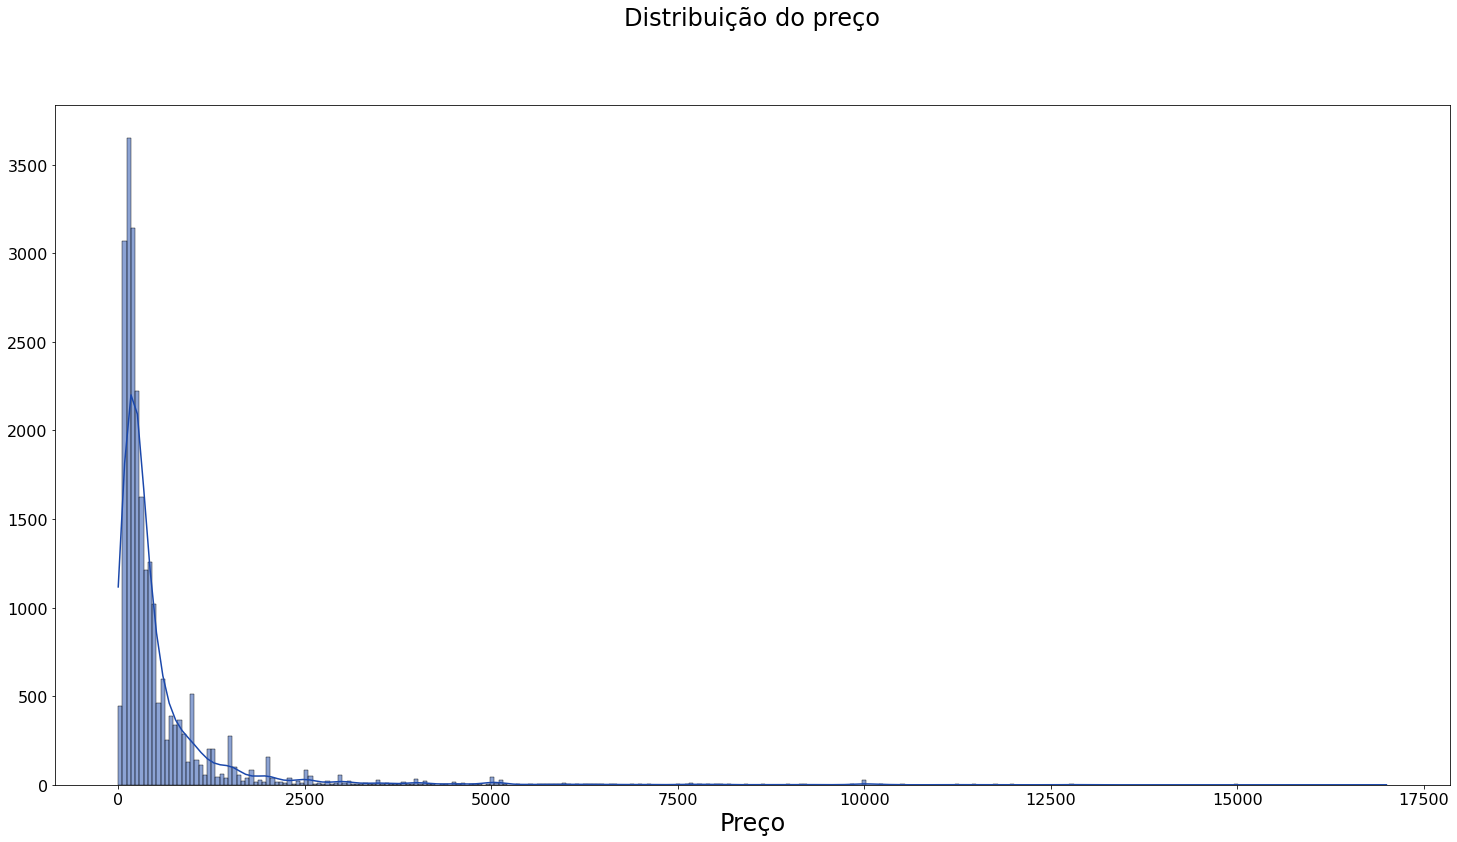

In [0]:
fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

hist_price_df = base_df.where(col("price") <= price_upper_limit)

sns.histplot(data=hist_price_df.toPandas()["price"], color=MAIN_COLOR, ax=ax, kde=True, bins=300)

plt.xlabel("Preço", fontsize=24)

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição do preço", pad=80, fontsize=24)

plt.show()

Com isso percebemos que o preço é consistente até o valor de R$ 5.000 a diária, valores acima possuem pouca probabilidade de existir nesse dataset e serão considerados outliers.

In [0]:
# Atualizando o limite superior do preço de acordo com a análise do Histograma dos preços. 

price_upper_limit = 5000

In [0]:
# Filtrando o dataset com base em valores mínimos maiores do que zero e o preço baseado no limite superior

filtered_df = base_df.filter((col("price") > price_lower_limit) & (col("price") <= price_upper_limit)) \
                    .filter(col("host_listings_count") > 0) \
                    .filter(col("bathrooms") > 0) \
                    .filter(col("beds") > 0) \
                    .filter(col("bedrooms") > 0) \
                    .filter(col("availability_30") > 0) \
                    .filter(col("availability_90") > 0) \
                    .filter(col("availability_365") > 0) \
                    .filter(col("number_of_reviews") > 0) 


filtered_df.limit(5).display()

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type amenities price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable f t t within an hour 100.0 98.0 Copacabana -22.96599 -43.1794 Entire condominium ["Bed linens", "Hangers", "Cooking basics", "Essentials", "Coffee maker", "Stove", "Patio or balcony", "Hot water", "TV with standard cable", "Luggage dropoff allowed", "Oven", "Private entrance", "Paid parking off premises", "Long term stays allowed", "Building staff", "Iron", "Elevator", "Air conditioning", "Microwave", "Wifi", "Kitchen", "Hot tub", "Dedicated workspace", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] 170.0 Entire home/apt 5.0 1.0 2.0 2.0 5.0 19.0 49.0 79.0 317.0 265.0 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t f t t a few days or more 40.0 21.0 Copacabana -22.97735 -43.19105 Entire apartment ["Cable TV", "Kitchen", "Hangers", "Long term stays allowed", "Essentials", "Dedicated workspace", "Iron", "Elevator", "Air conditioning", "Hair dryer", "Wifi", "Bed linens", "TV with standard cable"] 160.0 Entire home/apt 2.0 1.0 1.0 2.0 7.0 29.0 59.0 89.0 316.0 238.0 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f t f t within an hour 100.0 98.0 Copacabana -22.98107 -43.19136 Entire loft ["Bed linens", "Hangers", "Cooking basics", "Smoke alarm", "Essentials", "Coffee maker", "Stove", "Hot water", "Room-darkening shades", "TV with standard cable", "Extra pillows and blankets", "Luggage dropoff allowed", "Paid parking off premises", "Carbon monoxide alarm", "Fire extinguisher", "Building staff", "Iron", "Elevator", "Air conditioning", "Microwave", "Wifi", "Kitchen", "Dedicated workspace", "Beachfront", "Pocket wifi", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] 120.0 Entire home/apt 2.0 1.0 1.0 1.0 3.0 5.0 14.0 26.0 92.0 363.0 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f f t t within an hour 100.0 84.0 Ipanema -22.98591 -43.20302 Entire apartment ["Bed linens", "Hangers", "Cooking basics", "Smoke alarm", "Essentials", "Washer", "Coffee maker", "Stove", "Patio or balcony", "Crib", "Extra pillows and blankets", "TV with standard cable", "Luggage dropoff allowed", "Oven", "Private entrance", "Paid parking on premises", "Cleaning products", "Long term stays allowed", "Shampoo", "Carbon monoxide alarm", "Fire extinguisher", "Iron", "Air conditioning", "Refrigerator", "Wifi", "Dryer", "Hair dryer", "Kitchen", "Lockbox", "Dedicated workspace", "Hot water", "Dishes and silverware", "Cable TV", "Microwave"] 1699.0 Entire home/apt 13.0 15.0 6.0 7.0 2.0 17.0 42.0 70.0 324.0 82.0 4.62 4.62 4.64 4.69 4.66 4.92 4.44 t f t t N/A null 100.0 Copacabana -22.98528 -43.19264 Private room in apartment ["Bed linens", "First aid kit", "Hangers", "Cooking basics", "Essentials", "Heating", "Washer", "Coffee maker", "Stove", "Hot water", "TV with standard cable", "Extra pillows and blankets", "Luggage dropoff allowed", "Oven", "Long term stays allowed", "Shampoo", "Fire extinguisher", "Building staff", "Iron", "Elevator", "Air conditioning", "Free street parking", "Microwave", "Wifi", "Lock on bedroom door", "Breakfast", "Dedicated workspace", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] 102.0 Private room 1.0 1.0 1.0 1.0 3.0 29.0 59.0 89.0 89.0 42.0 4.88 4.93 4.86 4.98 5.0 4.98 4.93 t

#### 3.4. Tratando valores nulos

Para que possamos trabalhar somente com dados válidos, iremos remover os valores nulos de features determinantes para um bom modelo de predição.

In [0]:
columns_to_filter_nulls = [
  "host_is_superhost",
  "host_identity_verified",
  "neighbourhood_cleansed",
  "latitude",
  "longitude",
  "number_of_reviews"
]

filtered_df = filtered_df.dropna(subset=columns_to_filter_nulls)

In [0]:
# Checando novamente a porcentagem de valores nulos 

filtered_df.select(
              [
                (count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in filtered_df.columns
              ]
              ) \
      .display()

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type amenities price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable 0.0 0.0 0.0 0.0 0.303603071470762 0.2603859027367592 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.03465249064776531 0.03465249064776531 0.03465249064776531 0.03455404607206143 0.034750935223469184 0.03465249064776531 0.0

#### 3.5. Imputando dados

Após ter removido alguns valores nulos, iremos imputar valores para as notas de revisão dos usuários para ter uma maior assertividade dos dados na hora de criar o modelo. O método a ser utilizado para o impute será a média.

In [0]:
impute_cols = [
  "review_scores_accuracy",
  "review_scores_cleanliness",
  "review_scores_checkin",
  "review_scores_communication",
  "review_scores_location",
  "review_scores_value",
  "host_response_rate",
  "host_acceptance_rate"
]

for c in impute_cols:
  print("Criação da coluna {}".format(c + "_na"))
  filtered_df = filtered_df.withColumn(c + "_na", when(col(c).isNull(), 1.0).otherwise(0.0))
  
imputer = Imputer(strategy="median", inputCols=impute_cols, outputCols=impute_cols)

imputer_model = imputer.fit(filtered_df)
imputed_df = imputer_model.transform(filtered_df)

Criação da coluna review_scores_accuracy_na
Criação da coluna review_scores_cleanliness_na
Criação da coluna review_scores_checkin_na
Criação da coluna review_scores_communication_na
Criação da coluna review_scores_location_na
Criação da coluna review_scores_value_na
Criação da coluna host_response_rate_na
Criação da coluna host_acceptance_rate_na


In [0]:
# Visualizando o dataset após o impute dos dados. As colunas com o final _na significa que aquele valor foi imputado.

imputed_df.limit(5).display()

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type amenities price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable review_scores_accuracy_na review_scores_cleanliness_na review_scores_checkin_na review_scores_communication_na review_scores_location_na review_scores_value_na host_response_rate_na host_acceptance_rate_na f t t within an hour 100.0 98.0 Copacabana -22.96599 -43.1794 Entire condominium ["Bed linens", "Hangers", "Cooking basics", "Essentials", "Coffee maker", "Stove", "Patio or balcony", "Hot water", "TV with standard cable", "Luggage dropoff allowed", "Oven", "Private entrance", "Paid parking off premises", "Long term stays allowed", "Building staff", "Iron", "Elevator", "Air conditioning", "Microwave", "Wifi", "Kitchen", "Hot tub", "Dedicated workspace", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] 170.0 Entire home/apt 5.0 1.0 2.0 2.0 5.0 19.0 49.0 79.0 317.0 265.0 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 f t t a few days or more 40.0 21.0 Copacabana -22.97735 -43.19105 Entire apartment ["Cable TV", "Kitchen", "Hangers", "Long term stays allowed", "Essentials", "Dedicated workspace", "Iron", "Elevator", "Air conditioning", "Hair dryer", "Wifi", "Bed linens", "TV with standard cable"] 160.0 Entire home/apt 2.0 1.0 1.0 2.0 7.0 29.0 59.0 89.0 316.0 238.0 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 t f t within an hour 100.0 98.0 Copacabana -22.98107 -43.19136 Entire loft ["Bed linens", "Hangers", "Cooking basics", "Smoke alarm", "Essentials", "Coffee maker", "Stove", "Hot water", "Room-darkening shades", "TV with standard cable", "Extra pillows and blankets", "Luggage dropoff allowed", "Paid parking off premises", "Carbon monoxide alarm", "Fire extinguisher", "Building staff", "Iron", "Elevator", "Air conditioning", "Microwave", "Wifi", "Kitchen", "Dedicated workspace", "Beachfront", "Pocket wifi", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] 120.0 Entire home/apt 2.0 1.0 1.0 1.0 3.0 5.0 14.0 26.0 92.0 363.0 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 f t t within an hour 100.0 84.0 Ipanema -22.98591 -43.20302 Entire apartment ["Bed linens", "Hangers", "Cooking basics", "Smoke alarm", "Essentials", "Washer", "Coffee maker", "Stove", "Patio or balcony", "Crib", "Extra pillows and blankets", "TV with standard cable", "Luggage dropoff allowed", "Oven", "Private entrance", "Paid parking on premises", "Cleaning products", "Long term stays allowed", "Shampoo", "Carbon monoxide alarm", "Fire extinguisher", "Iron", "Air conditioning", "Refrigerator", "Wifi", "Dryer", "Hair dryer", "Kitchen", "Lockbox", "Dedicated workspace", "Hot water", "Dishes and silverware", "Cable TV", "Microwave"] 1699.0 Entire home/apt 13.0 15.0 6.0 7.0 2.0 17.0 42.0 70.0 324.0 82.0 4.62 4.62 4.64 4.69 4.66 4.92 4.44 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 f t t N/A 100.0 100.0 Copacabana -22.98528 -43.19264 Private room in apartment ["Bed linens", "First aid kit", "Hangers", "Cooking basics", "Essentials", "Heating", "Washer", "Coffee maker", "Stove", "Hot water", "TV with standard cable", "Extra pillows and blankets", "Luggage dropoff allowed", "Oven", "Long term stays allowed", "Shampoo", "Fire extinguisher", "Building staff", "Iron", "Elevator", "Air conditioning", "Free street parking", "Microwave", "Wifi", "Lock on bedroom door", "Breakfast", "Dedicated workspace", "Hair dryer", "Dishes and silverware", "Cable TV", "Refrigerator"] 102.0 Private room 1.0 1.0 1.0 1.0 3.0 29.0 59.0 89.0 89.0 42.0 4.88 4.93 4.86 4.98 5.0 4.98 4.93 t 0.0 0.0 

#### 3.6. Transformando a feature amenities em sub-features

Importante estudar os impactos das comodidades do Airbnb no preço do Arinbnb. Como temos muitas, iremos escolher as comodidades mais populosas.

In [0]:
# Capturando as 30 comodidades mais recorrentes no Dataset

counter_results = Counter()

df = imputed_df.toPandas()

print("As 30 comodidades mais recorrentes são:")

df['amenities'].str.strip('[]')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.lower()\
               .str.split(',')\
               .apply(counter_results.update)

counter_results.most_common(30)

As 30 comodidades mais recorrentes são:
Out[21]: [(' wifi', 9293),
 (' essentials', 9026),
 (' long term stays allowed', 8810),
 (' air conditioning', 8277),
 (' kitchen', 7519),
 (' iron', 7361),
 (' elevator', 6955),
 (' hot water', 6776),
 (' dishes and silverware', 6351),
 (' washer', 6310),
 (' dedicated workspace', 6180),
 (' hangers', 5880),
 (' refrigerator', 5666),
 (' microwave', 5359),
 (' cooking basics', 5214),
 (' stove', 4900),
 (' hair dryer', 4852),
 (' coffee maker', 4825),
 (' tv with standard cable', 4404),
 (' cable tv', 4370),
 (' tv', 4347),
 (' oven', 4328),
 (' free parking on premises', 3598),
 (' extra pillows and blankets', 3104),
 (' fire extinguisher', 3015),
 (' luggage dropoff allowed', 2905),
 (' host greets you', 2664),
 ('bed linens', 2453),
 (' bed linens', 2429),
 (' free street parking', 2309)]

In [0]:
# Visualizando as comodidades mais recorrentes com sua frequência no dataset

sub_df = spark.createDataFrame(counter_results.most_common(30), ['amenity', 'count'])

sub_df.display()

amenity count wifi 9293 essentials 9026 long term stays allowed 8810 air conditioning 8277 kitchen 7519 iron 7361 elevator 6955 hot water 6776 dishes and silverware 6351 washer 6310 dedicated workspace 6180 hangers 5880 refrigerator 5666 microwave 5359 cooking basics 5214 stove 4900 hair dryer 4852 coffee maker 4825 tv with standard cable 4404 cable tv 4370 tv 4347 oven 4328 free parking on premises 3598 extra pillows and blankets 3104 fire extinguisher 3015 luggage dropoff allowed 2905 host greets you 2664 bed linens 2453 bed linens 2429 free street parking 2309

In [0]:
# Inserindo as novas colunas relativos às comodiadades selecionadas que recebe 'true' caso essa comodidade esteja listada no Airbnb e 'false' caso contrário


for row in sub_df.rdd.collect():
  column_name = row["amenity"].strip().replace(' ', '_')
  
  feature_like = row["amenity"].strip().lower()
  
  imputed_df = imputed_df.withColumn(column_name, lower(col("amenities")).contains(feature_like))
  
  print('Coluna {} inserida!'.format(column_name))
    


Coluna wifi inserida!
Coluna essentials inserida!
Coluna long_term_stays_allowed inserida!
Coluna air_conditioning inserida!
Coluna kitchen inserida!
Coluna iron inserida!
Coluna elevator inserida!
Coluna hot_water inserida!
Coluna dishes_and_silverware inserida!
Coluna washer inserida!
Coluna dedicated_workspace inserida!
Coluna hangers inserida!
Coluna refrigerator inserida!
Coluna microwave inserida!
Coluna cooking_basics inserida!
Coluna stove inserida!
Coluna hair_dryer inserida!
Coluna coffee_maker inserida!
Coluna tv_with_standard_cable inserida!
Coluna cable_tv inserida!
Coluna tv inserida!
Coluna oven inserida!
Coluna free_parking_on_premises inserida!
Coluna extra_pillows_and_blankets inserida!
Coluna fire_extinguisher inserida!
Coluna luggage_dropoff_allowed inserida!
Coluna host_greets_you inserida!
Coluna bed_linens inserida!
Coluna bed_linens inserida!
Coluna free_street_parking inserida!


In [0]:
cleaned_df = imputed_df.drop("amenities")

cleaned_df.limit(5).display()

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable review_scores_accuracy_na review_scores_cleanliness_na review_scores_checkin_na review_scores_communication_na review_scores_location_na review_scores_value_na host_response_rate_na host_acceptance_rate_na wifi essentials long_term_stays_allowed air_conditioning kitchen iron elevator hot_water dishes_and_silverware washer dedicated_workspace hangers refrigerator microwave cooking_basics stove hair_dryer coffee_maker tv_with_standard_cable cable_tv tv oven free_parking_on_premises extra_pillows_and_blankets fire_extinguisher luggage_dropoff_allowed host_greets_you bed_linens free_street_parking f t t within an hour 100.0 98.0 Copacabana -22.96599 -43.1794 Entire condominium 170.0 Entire home/apt 5.0 1.0 2.0 2.0 5.0 19.0 49.0 79.0 317.0 265.0 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true true true false true true true true true true true true true true true true false false false true false true false f t t a few days or more 40.0 21.0 Copacabana -22.97735 -43.19105 Entire apartment 160.0 Entire home/apt 2.0 1.0 1.0 2.0 7.0 29.0 59.0 89.0 316.0 238.0 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true false false false true true false false false false true false true true true false false false false false false true false t f t within an hour 100.0 98.0 Copacabana -22.98107 -43.19136 Entire loft 120.0 Entire home/apt 2.0 1.0 1.0 1.0 3.0 5.0 14.0 26.0 92.0 363.0 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true false true true true true true true false true true true true true true true true true true true false false true true true false true false f t t within an hour 100.0 84.0 Ipanema -22.98591 -43.20302 Entire apartment 1699.0 Entire home/apt 13.0 15.0 6.0 7.0 2.0 17.0 42.0 70.0 324.0 82.0 4.62 4.62 4.64 4.69 4.66 4.92 4.44 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true false true true true true true true true true true true true true true true true false true true true false true false f t t N/A 100.0 100.0 Copacabana -22.98528 -43.19264 Private room in apartment 102.0 Private room 1.0 1.0 1.0 1.0 3.0 29.0 59.0 89.0 89.0 42.0 4.88 4.93 4.86 4.98 5.0 4.98 4.93 t 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 true true true true false true true true true true true true true true true true true true true true true true false true true true false true true

### Salvando o novo dataset

In [0]:
# cleaned_df.write.mode("overwrite").option("overwriteSchema", "true").save(OUTPUT_DATASET_PATH)

In [0]:
# Visualizando a tabela
# dbutils.fs.ls(OUTPUT_DATASET_PATH)

### 4. Explorando os dados

#### 4.1 Analisando as features categóricas

#### 4.1.1. Analisando os tipos de quarto

In [0]:
airbnb_df = cleaned_df

df = airbnb_df.toPandas()

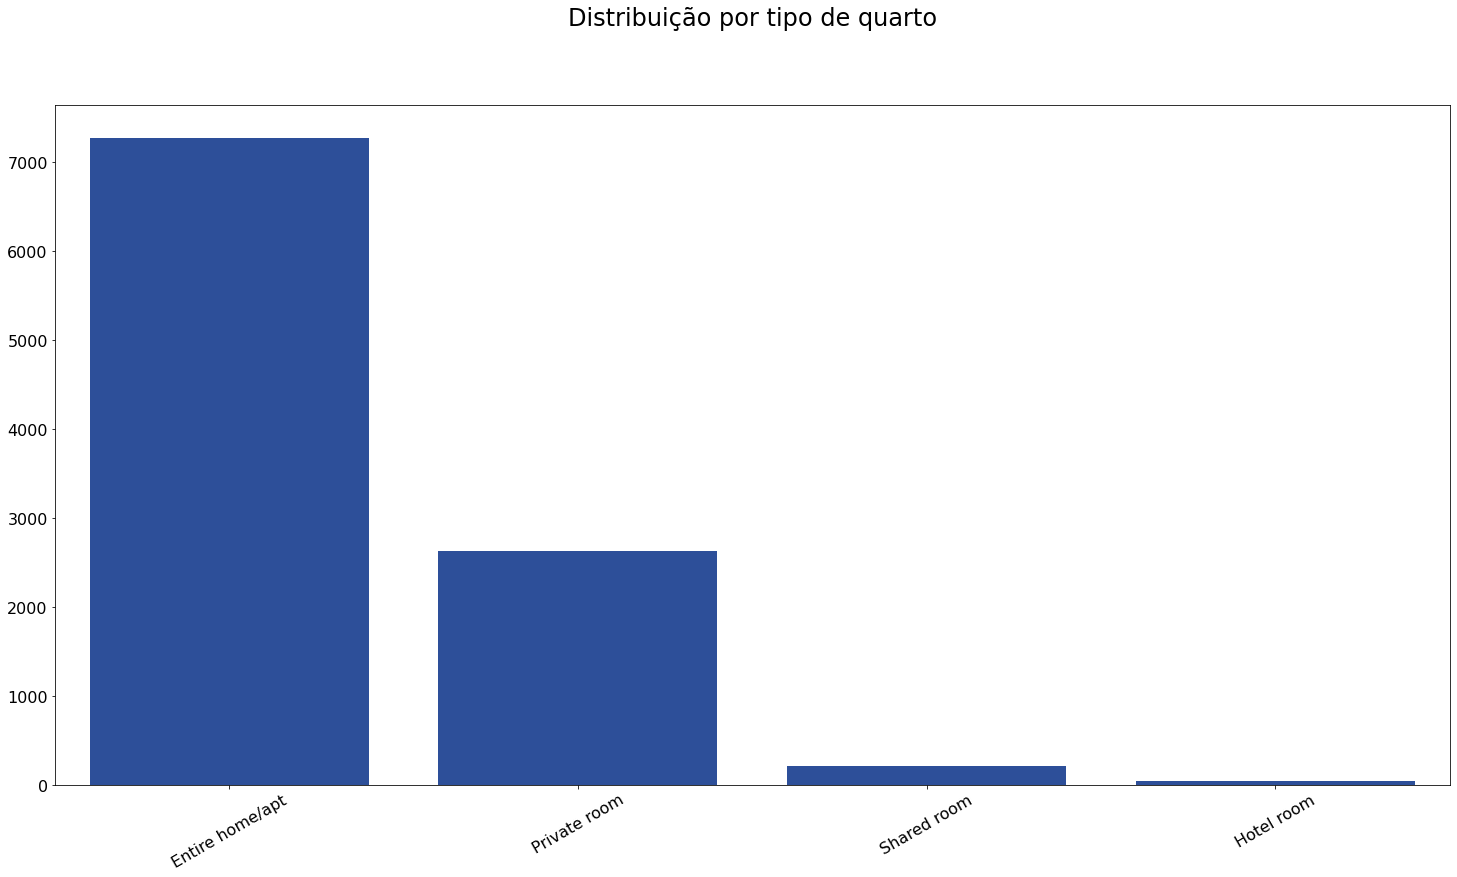

In [0]:
# Visualizando os tipos de quarto

room_type_count = airbnb_df.groupBy("room_type").count().orderBy("count", ascending=False).toPandas()

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(x="room_type", y="count", data=room_type_count, color=MAIN_COLOR, ax=ax)

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição por tipo de quarto", pad=80, fontsize=24)

plt.show()


In [0]:
# Visualizando os tipos de quarto

room_type_count.display()

room_type count Entire home/apt 7277 Private room 2632 Shared room 209 Hotel room 40

### 4.1.2. Analisando os tipos de propriedade

#### 4.1.2.1 Visualizando os tipos de propriedade

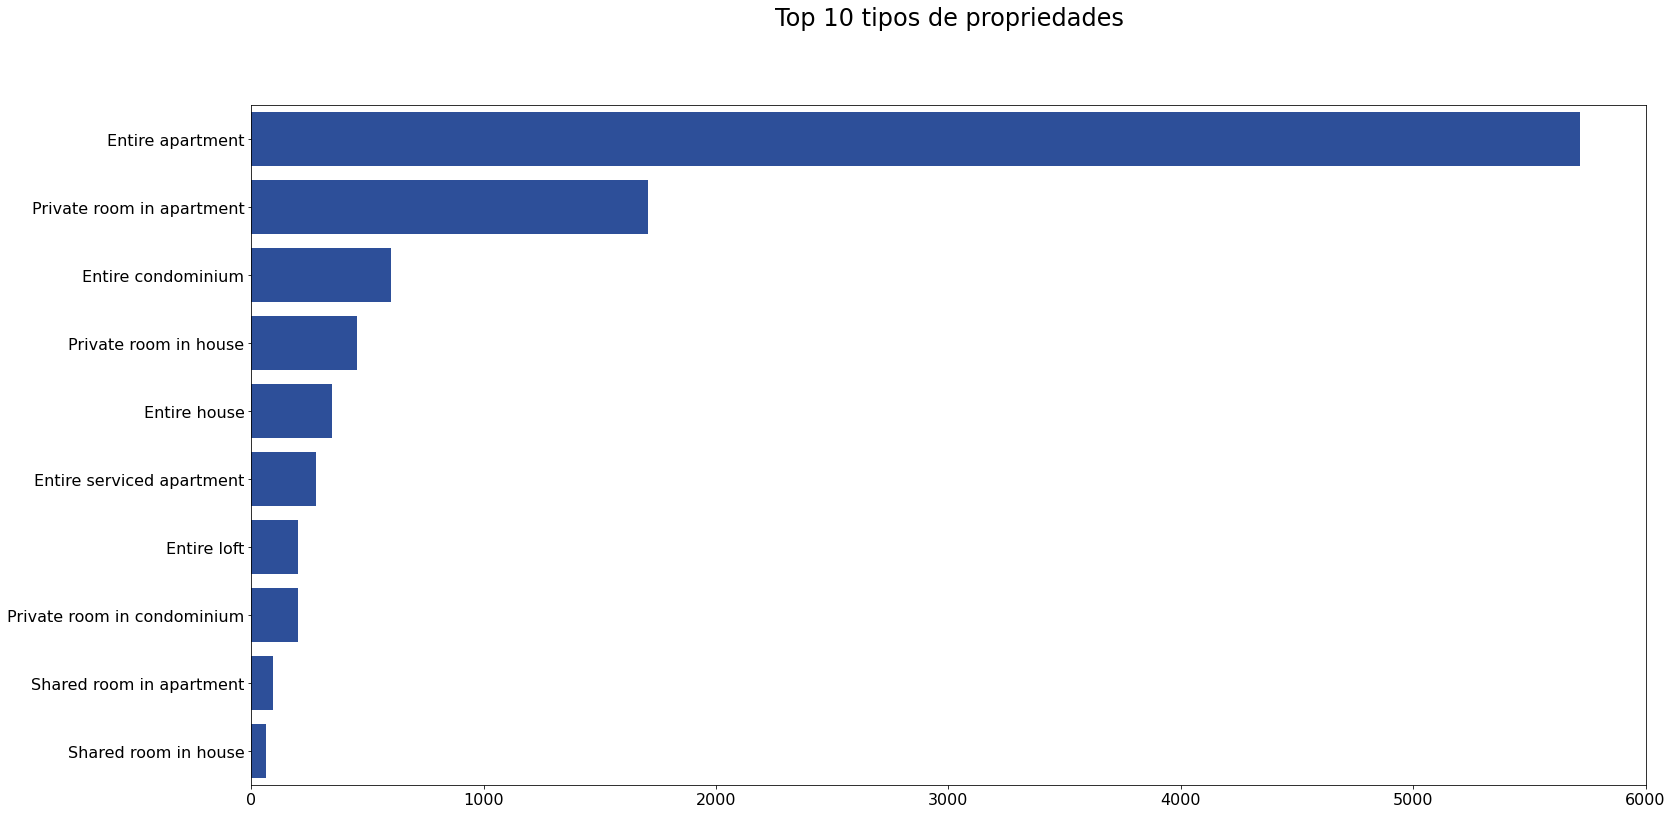

In [0]:
#  Visualizando os tipos de propriedade

property_type_count = airbnb_df.groupBy("property_type").count().orderBy("count", ascending=False).toPandas()

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(y="property_type", x="count", data=property_type_count[:10], color=MAIN_COLOR, ax=ax, orient='h')

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Top 10 tipos de propriedades", pad=80, fontsize=24)

plt.show()

In [0]:
# Visualizando a quantidade de Airbnb por propriedade

property_type_count.display()

property_type count Entire apartment 5718 Private room in apartment 1706 Entire condominium 599 Private room in house 453 Entire house 348 Entire serviced apartment 279 Entire loft 201 Private room in condominium 200 Shared room in apartment 92 Shared room in house 63 Private room in bed and breakfast 47 Private room in guest suite 45 Entire guesthouse 32 Room in hotel 31 Entire guest suite 30 Private room in serviced apartment 26 Room in boutique hotel 25 Private room in townhouse 21 Shared room in hostel 20 Private room in loft 17 Room in aparthotel 17 Private room in guesthouse 17 Entire villa 14 Room in serviced apartment 13 Shared room in bed and breakfast 13 Private room in hostel 11 Shared room in condominium 9 Private room in nature lodge 8 Private room in villa 8 Entire chalet 7 Entire place 7 Entire townhouse 7 Private room in cottage 6 Tiny house 6 Private room in earth house 5 Room in bed and breakfast 5 Room in hostel 5 Entire cottage 5 Private room in chalet 4 Shared room in guesthouse 4 Private room 4 Private room in tiny house 4 Shared room in loft 3 Entire bungalow 3 Entire cabin 2 Boat 2 Private room in barn 1 Private room in island 1 Entire dorm 1 Room in nature lodge 1 Shared room in serviced apartment 1 Earth house 1 Treehouse 1 Private room in cabin 1 Private room in floor 1 Shared room in guest suite 1 Shared room in cottage 1 Island 1 Private room in tent 1 Houseboat 1 Shared room in nature lodge 1 Shared room in villa 1

#### 4.1.2.2 Visualizando a média de preços da diária por tipo de propriedade

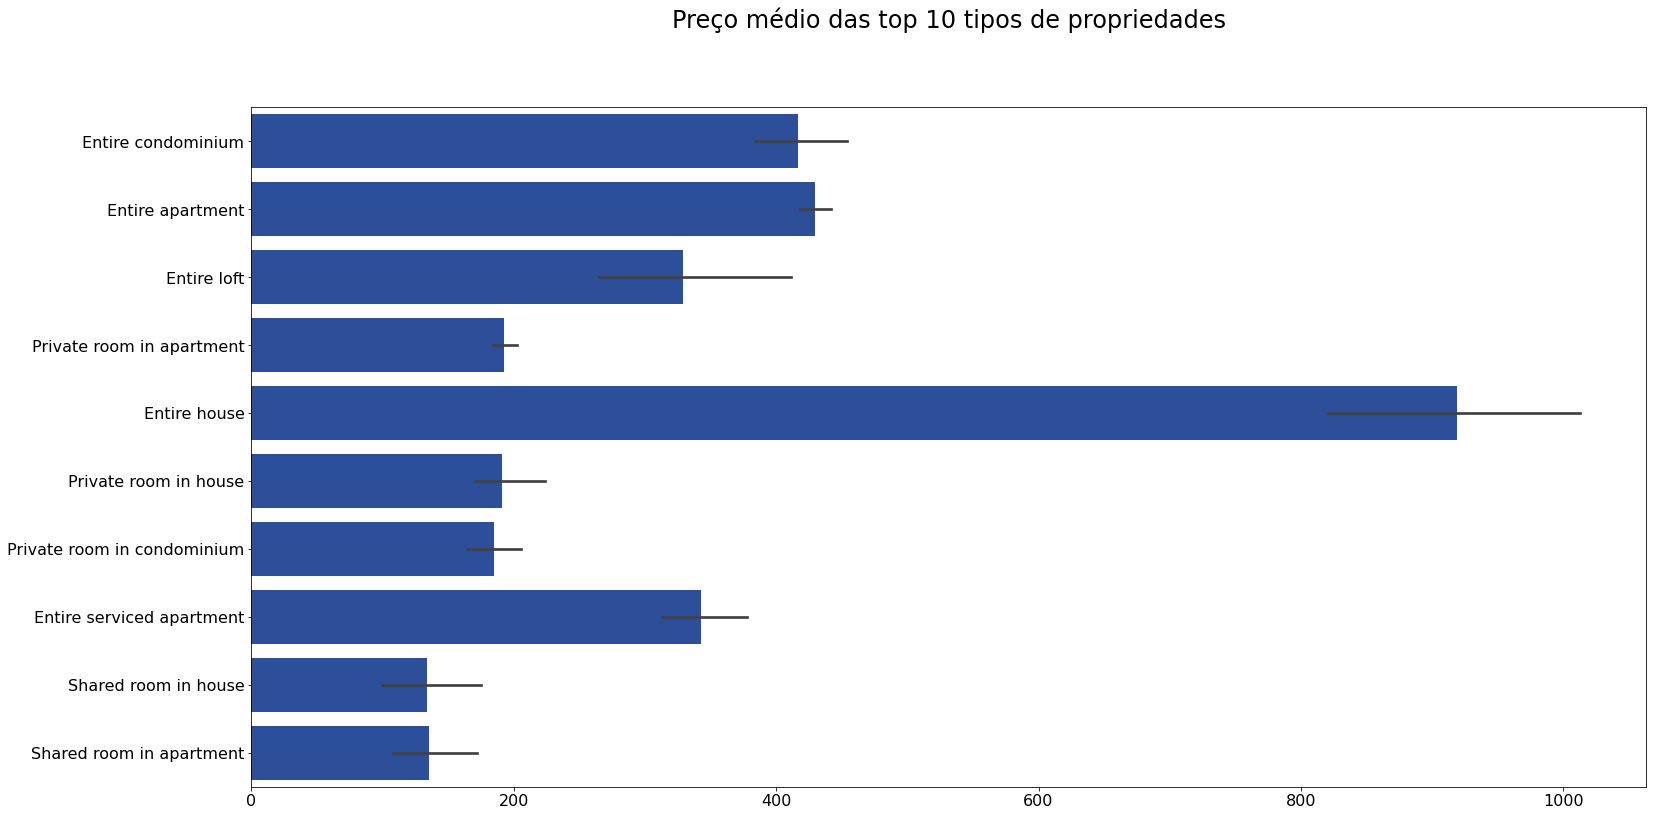

In [0]:
# Visualizando o preço médio do top 10 tipos de propriedade

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(
            y="property_type",
            x="price",
            data=df[df['property_type'].isin(property_type_count[:10]['property_type'])],
            color=MAIN_COLOR,
            ax=ax,
            orient='h',
            )

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Preço médio das top 10 tipos de propriedades", pad=80, fontsize=24)

plt.show()

In [0]:
# Visualizando o preço médio por tipo de propriedades

df.groupby('property_type') \
  .mean() \
  .reset_index()[['property_type', 'price']] \
  .display()

property_type price Boat 2150.0 Earth house 120.0 Entire apartment 429.8711087792935 Entire bungalow 174.33333333333334 Entire cabin 577.0 Entire chalet 312.0 Entire condominium 417.01669449081805 Entire cottage 1104.4 Entire dorm 99.0 Entire guest suite 173.43333333333334 Entire guesthouse 188.40625 Entire house 919.2097701149426 Entire loft 328.8059701492537 Entire place 257.85714285714283 Entire serviced apartment 342.39068100358423 Entire townhouse 255.85714285714286 Entire villa 1703.2857142857142 Houseboat 4500.0 Island 141.0 Private room 281.5 Private room in apartment 192.26260257913248 Private room in barn 356.0 Private room in bed and breakfast 202.4468085106383 Private room in cabin 100.0 Private room in chalet 426.0 Private room in condominium 185.255 Private room in cottage 217.83333333333334 Private room in earth house 148.0 Private room in floor 62.0 Private room in guest suite 179.86666666666667 Private room in guesthouse 190.0 Private room in hostel 112.63636363636364 Private room in house 191.06843267108167 Private room in island 300.0 Private room in loft 197.05882352941177 Private room in nature lodge 337.625 Private room in serviced apartment 158.03846153846155 Private room in tent 54.0 Private room in tiny house 206.5 Private room in townhouse 113.76190476190476 Private room in villa 144.75 Room in aparthotel 395.29411764705884 Room in bed and breakfast 90.2 Room in boutique hotel 334.8 Room in hostel 153.4 Room in hotel 339.80645161290323 Room in nature lodge 65.0 Room in serviced apartment 423.38461538461536 Shared room in apartment 135.70652173913044 Shared room in bed and breakfast 110.3076923076923 Shared room in condominium 110.33333333333333 Shared room in cottage 150.0 Shared room in guest suite 150.0 Shared room in guesthouse 118.25 Shared room in hostel 63.1 Shared room in house 133.73015873015873 Shared room in loft 55.333333333333336 Shared room in nature lodge 56.0 Shared room in serviced apartment 260.0 Shared room in villa 75.0 Tiny house 114.33333333333333 Treehouse 260.0

### 4.1.3. Visualizando a distribuição dos bairros

#### 4.1.3.1. Visualizando a distribuição de Airbnb por bairro

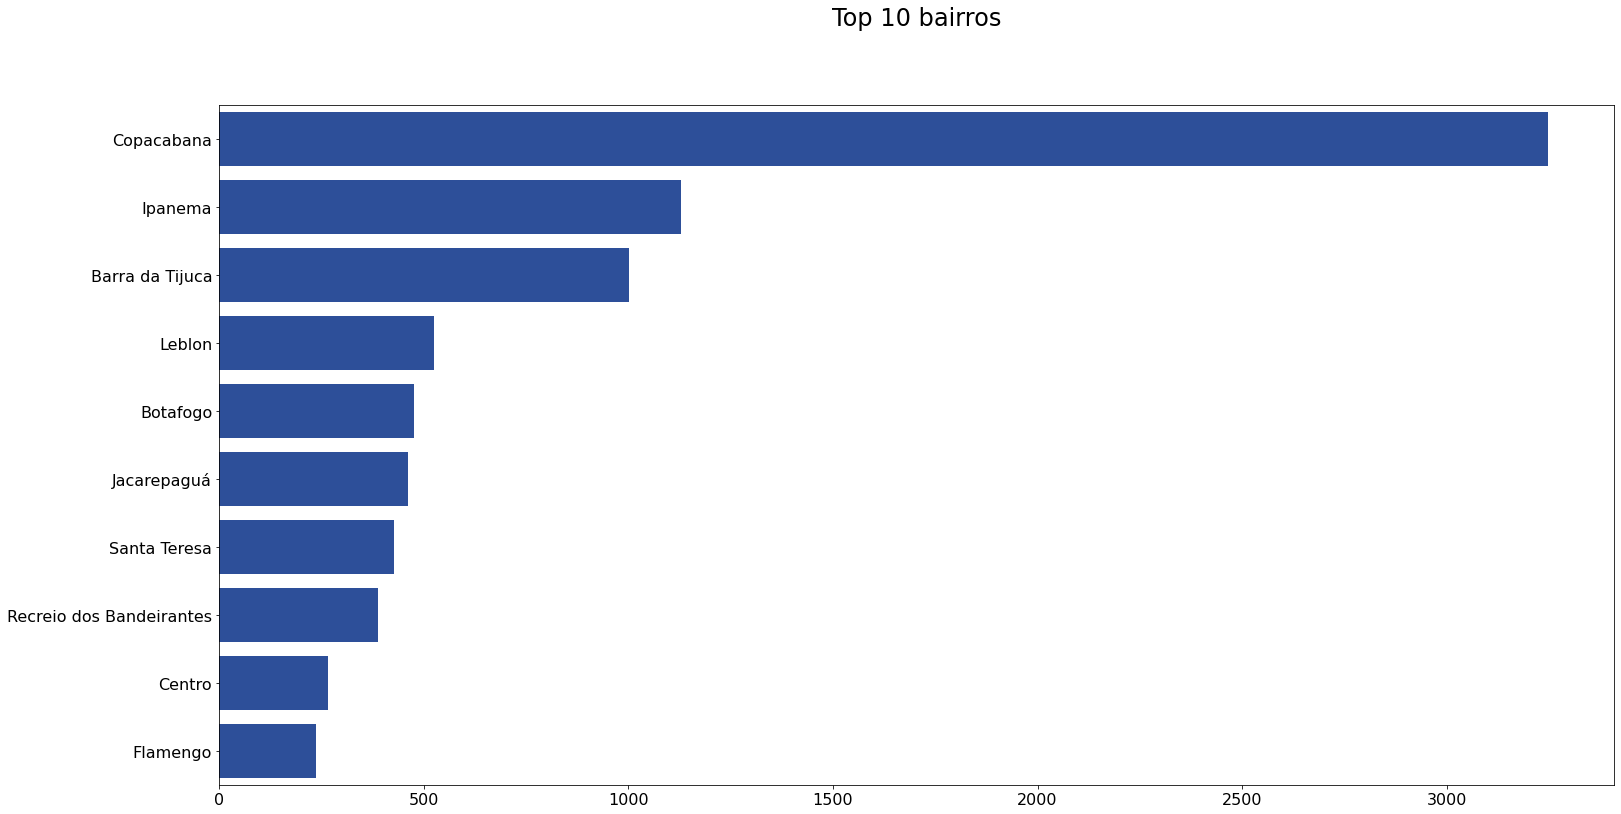

In [0]:
#  Visualizando a distribuição de Airbnb por bairro

neighbourhood_cleansed_count = airbnb_df.groupBy("neighbourhood_cleansed").count().orderBy("count", ascending=False).toPandas()

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(y="neighbourhood_cleansed", x="count", data=neighbourhood_cleansed_count[:10], color=MAIN_COLOR, ax=ax, orient='h')

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Top 10 bairros", pad=80, fontsize=24)

plt.show()

In [0]:
# Visualizando a distribuição de Aribnb por bairro

neighbourhood_cleansed_count.display()

neighbourhood_cleansed count Copacabana 3247 Ipanema 1128 Barra da Tijuca 1002 Leblon 524 Botafogo 477 Jacarepaguá 462 Santa Teresa 426 Recreio dos Bandeirantes 388 Centro 265 Flamengo 236 Leme 184 Laranjeiras 153 Tijuca 133 Camorim 90 Lagoa 89 Glória 86 Catete 82 Gávea 75 Jardim Botânico 71 São Conrado 67 Humaitá 63 Vidigal 55 Urca 47 Freguesia (Jacarepaguá) 37 Maracanã 35 Cosme Velho 34 Itanhangá 33 Vila Isabel 32 São Cristóvão 32 Vargem Pequena 31 Taquara 31 Barra de Guaratiba 30 Rio Comprido 29 Campo Grande 27 Vargem Grande 27 Joá 24 Estácio 23 Guaratiba 23 Curicica 23 Paquetá 16 Jardim Guanabara 14 Portuguesa 13 Praça da Bandeira 13 Grajaú 13 Alto da Boa Vista 12 Andaraí 12 Engenho Novo 11 Engenho de Dentro 11 Brás de Pina 11 Anil 10 Pechincha 10 Todos os Santos 9 Vila Valqueire 9 Irajá 9 Penha 8 Del Castilho 8 Cachambi 8 Méier 7 Cidade Nova 7 Gardênia Azul 6 Gamboa 6 Praça Seca 5 Marechal Hermes 5 Maria da Graça 5 Rocha 4 Bonsucesso 4 Penha Circular 4 São Francisco Xavier 4 Rocinha 3 Jardim Sulacap 3 Pitangueiras 3 Bangu 3 Engenho da Rainha 2 Pedra de Guaratiba 2 Senador Vasconcelos 2 Ramos 2 Guadalupe 2 Santa Cruz 2 Olaria 2 Inhaúma 2 Madureira 2 Campinho 2 Cidade de Deus 2 Riachuelo 2 Inhoaíba 2 Saúde 2 Vasco da Gama 2 Galeão 2 Complexo do Alemão 2 Cordovil 2 Catumbi 2 Benfica 2 Tomás Coelho 1 Realengo 1 Bento Ribeiro 1 Vicente de Carvalho 1 Grumari 1 Santo Cristo 1 Gericinó 1 Piedade 1 Lins de Vasconcelos 1 Encantado 1 Parada de Lucas 1 Tauá 1 Zumbi 1 Vila Militar 1 Sampaio 1 Parque Anchieta 1 Cidade Universitária 1 Honório Gurgel 1 Vila da Penha 1 Tanque 1 Bancários 1 Sepetiba 1 Cosmos 1 Mangueira 1 Deodoro 1 Osvaldo Cruz 1 Senador Camará 1 Pilares 1 Freguesia (Ilha) 1 Jacaré 1 Quintino Bocaiúva 1

Visualizando um mapa de calor que evidencia os locais em que possuem a maior concentração de Airbnbs.

In [0]:
# Visualizando um mapa de calor que evidencia os locais em que possuem a maior concentração de Airbnbs

rio_map = folium.Map([-22.9032, -43.1929], zoom_start=12) 

HeatMap(df[['latitude','longitude']].dropna(), 
       radius=10, gradient={0.2:'green',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(rio_map)


# Commented because browser wasn't showing markers
#df_listings.sample(frac=0.1).apply(lambda row:folium.Marker(location=[row["latitude"], row["longitude"]], 
#                                         popup=row['name']).add_to(rio_map), axis=1)
rio_map

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_a59e957fbbdb4a11bf8a41d134c03701%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium%40master/folium/templates/leaflet_heat.min.js%22%3E%3C/script%3E%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_a59e957fbbdb4a11bf8a41d134c03701%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_a59e957fbbdb4a11bf8a41d134c03701%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_a59e957fbbdb4a11bf8a41d134c03701%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B-22.9032%2C%20-43.1929%5D%2C%0A%20%20%20%20%20%20%20%20%2

### 4.1.3.2. Visualizando o preço médio por bairro

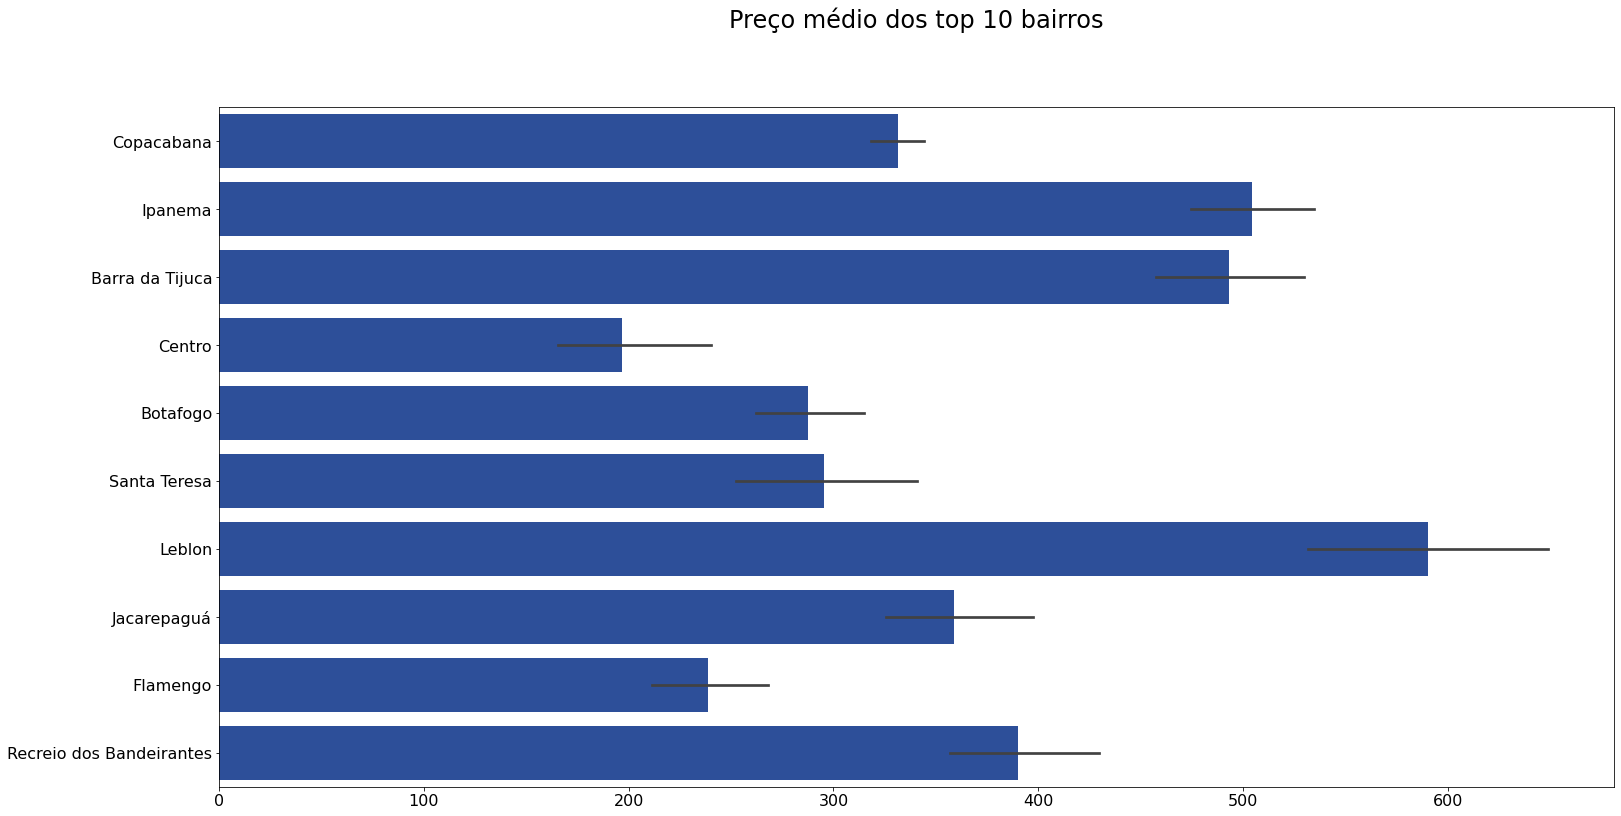

In [0]:
# Visualizando o preço médio dos top 10 bairros

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(
            y="neighbourhood_cleansed",
            x="price",
            data=df[df['neighbourhood_cleansed'].isin(neighbourhood_cleansed_count[:10]['neighbourhood_cleansed'])],
            color=MAIN_COLOR,
            ax=ax,
            orient='h',
            )

plt.xlabel("")

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Preço médio dos top 10 bairros", pad=80, fontsize=24)

plt.show()

In [0]:
# Visualizando o preço médio por bairro

df.groupby('neighbourhood_cleansed') \
  .mean() \
  .reset_index()[['neighbourhood_cleansed', 'price']] \
  .display()

neighbourhood_cleansed price Alto da Boa Vista 585.75 Andaraí 127.33333333333333 Anil 237.4 Bancários 160.0 Bangu 264.3333333333333 Barra da Tijuca 492.99600798403196 Barra de Guaratiba 406.73333333333335 Benfica 55.0 Bento Ribeiro 95.0 Bonsucesso 96.0 Botafogo 287.7169811320755 Brás de Pina 94.72727272727273 Cachambi 364.0 Camorim 266.5777777777778 Campinho 194.5 Campo Grande 197.7037037037037 Catete 260.3658536585366 Catumbi 80.0 Centro 196.8188679245283 Cidade Nova 278.0 Cidade Universitária 50.0 Cidade de Deus 204.0 Complexo do Alemão 520.0 Copacabana 331.3982137357561 Cordovil 146.0 Cosme Velho 468.70588235294116 Cosmos 150.0 Curicica 148.95652173913044 Del Castilho 292.5 Deodoro 84.0 Encantado 530.0 Engenho Novo 115.54545454545455 Engenho da Rainha 200.0 Engenho de Dentro 326.90909090909093 Estácio 172.56521739130434 Flamengo 238.50423728813558 Freguesia (Ilha) 1023.0 Freguesia (Jacarepaguá) 179.21621621621622 Galeão 83.5 Gamboa 161.0 Gardênia Azul 226.33333333333334 Gericinó 110.0 Glória 259.0232558139535 Grajaú 146.23076923076923 Grumari 141.0 Guadalupe 149.0 Guaratiba 630.6521739130435 Gávea 471.58666666666664 Honório Gurgel 78.0 Humaitá 280.77777777777777 Inhaúma 92.0 Inhoaíba 192.5 Ipanema 504.6436170212766 Irajá 209.88888888888889 Itanhangá 668.1818181818181 Jacarepaguá 358.63419913419915 Jacaré 50.0 Jardim Botânico 406.50704225352115 Jardim Guanabara 139.0 Jardim Sulacap 120.0 Joá 1396.1666666666667 Lagoa 630.3033707865169 Laranjeiras 267.51633986928107 Leblon 590.5038167938932 Leme 337.79347826086956 Lins de Vasconcelos 99.0 Madureira 94.0 Mangueira 130.0 Maracanã 267.57142857142856 Marechal Hermes 145.4 Maria da Graça 91.0 Méier 126.42857142857143 Olaria 92.0 Osvaldo Cruz 151.0 Paquetá 246.5 Parada de Lucas 149.0 Parque Anchieta 55.0 Pechincha 241.2 Pedra de Guaratiba 103.5 Penha 293.875 Penha Circular 137.75 Piedade 120.0 Pilares 420.0 Pitangueiras 116.0 Portuguesa 90.61538461538461 Praça Seca 75.8 Praça da Bandeira 161.46153846153845 Quintino Bocaiúva 148.0 Ramos 60.0 Realengo 829.0 Recreio dos Bandeirantes 390.35309278350513 Riachuelo 110.0 Rio Comprido 404.41379310344826 Rocha 155.0 Rocinha 143.33333333333334 Sampaio 307.0 Santa Cruz 147.5 Santa Teresa 295.6244131455399 Santo Cristo 74.0 Saúde 107.5 Senador Camará 66.0 Senador Vasconcelos 84.5 Sepetiba 707.0 São Conrado 692.6119402985074 São Cristóvão 264.3125 São Francisco Xavier 142.0 Tanque 199.0 Taquara 121.93548387096774 Tauá 75.0 Tijuca 184.62406015037595 Todos os Santos 217.11111111111111 Tomás Coelho 332.0 Urca 326.82978723404256 Vargem Grande 589.074074074074 Vargem Pequena 235.5483870967742 Vasco da Gama 100.0 Vicente de Carvalho 120.0 Vidigal 352.4909090909091 Vila Isabel 175.71875 Vila Militar 142.0 Vila Valqueire 347.6666666666667 Vila da Penha 113.0 Zumbi 149.0

Analisando os dados estatístico do peço dos Airbnb por cidade.

In [0]:
airbnb_df.groupBy("neighbourhood_cleansed"). \
                                            agg(
                                                count('price').alias('count'), \
                                                mean('price').alias('mean'), \
                                                stddev('price').alias('std'), \
                                                min('price').alias('min'), \
                                                expr('percentile(price, array(0.25))')[0].alias('%25'), \
                                                expr('percentile(price, array(0.5))')[0].alias('%50'), \
                                                expr('percentile(price, array(0.75))')[0].alias('%75'), \
                                                max('price').alias('max')
                                                ).display()

neighbourhood_cleansed count mean std min %25 %50 %75 max Gávea 75 471.58666666666664 659.6437837510798 50.0 153.5 275.0 411.5 3526.0 Tomás Coelho 1 332.0 null 332.0 332.0 332.0 332.0 332.0 Ipanema 1128 504.6436170212766 514.5801596146812 50.0 216.0 331.5 590.0 4800.0 Realengo 1 829.0 null 829.0 829.0 829.0 829.0 829.0 Gardênia Azul 6 226.33333333333334 147.55970543026527 51.0 100.25 235.0 360.0 380.0 Rocha 4 155.0 103.76254944182253 80.0 80.0 120.0 195.0 300.0 Bento Ribeiro 1 95.0 null 95.0 95.0 95.0 95.0 95.0 Vicente de Carvalho 1 120.0 null 120.0 120.0 120.0 120.0 120.0 Botafogo 477 287.7169811320755 302.2254876119746 49.0 115.0 196.0 300.0 2557.0 Jacarepaguá 462 358.63419913419915 377.4113482253995 50.0 150.0 250.0 410.0 4583.0 Leme 184 337.79347826086956 350.92816938302934 40.0 128.5 230.0 450.0 2816.0 Campo Grande 27 197.7037037037037 206.17651414687114 52.0 80.0 133.0 171.0 857.0 Rocinha 3 143.33333333333334 81.44527815247078 50.0 115.0 180.0 190.0 200.0 Grumari 1 141.0 null 141.0 141.0 141.0 141.0 141.0 Flamengo 236 238.50423728813558 235.19414339721962 50.0 100.75 170.0 291.25 1934.0 Engenho da Rainha 2 200.0 141.4213562373095 100.0 150.0 200.0 250.0 300.0 Santo Cristo 1 74.0 null 74.0 74.0 74.0 74.0 74.0 Pedra de Guaratiba 2 103.5 72.8319984622144 52.0 77.75 103.5 129.25 155.0 Gericinó 1 110.0 null 110.0 110.0 110.0 110.0 110.0 Piedade 1 120.0 null 120.0 120.0 120.0 120.0 120.0 Senador Vasconcelos 2 84.5 6.363961030678928 80.0 82.25 84.5 86.75 89.0 Lins de Vasconcelos 1 99.0 null 99.0 99.0 99.0 99.0 99.0 Encantado 1 530.0 null 530.0 530.0 530.0 530.0 530.0 Vila Isabel 32 175.71875 162.11868101446842 50.0 83.75 109.0 180.0 643.0 Parada de Lucas 1 149.0 null 149.0 149.0 149.0 149.0 149.0 Bonsucesso 4 96.0 51.062053751620034 50.0 72.5 82.5 106.0 169.0 Ramos 2 60.0 0.0 60.0 60.0 60.0 60.0 60.0 Tauá 1 75.0 null 75.0 75.0 75.0 75.0 75.0 Jardim Botânico 71 406.50704225352115 684.642636150724 50.0 138.0 245.0 369.0 4000.0 Guadalupe 2 149.0 72.12489168102785 98.0 123.5 149.0 174.5 200.0 Jardim Guanabara 14 139.0 64.09488159091836 65.0 98.0 134.0 158.25 300.0 Paquetá 16 246.5 168.7187008010671 90.0 120.0 237.5 277.5 800.0 Zumbi 1 149.0 null 149.0 149.0 149.0 149.0 149.0 Urca 47 326.82978723404256 358.6583283359476 56.0 129.0 200.0 317.5 1980.0 Recreio dos Bandeirantes 388 390.35309278350513 360.9380279442023 50.0 154.0 290.0 479.25 3200.0 Santa Cruz 2 147.5 81.31727983645297 90.0 118.75 147.5 176.25 205.0 Jardim Sulacap 3 120.0 36.05551275463989 80.0 105.0 130.0 140.0 150.0 Olaria 2 92.0 9.899494936611665 85.0 88.5 92.0 95.5 99.0 Estácio 23 172.56521739130434 121.4517585062842 57.0 90.5 130.0 235.0 550.0 Maracanã 35 267.57142857142856 259.29058031871654 50.0 85.0 170.0 295.0 1000.0 Leblon 524 590.5038167938932 655.0468390596787 54.0 278.0 400.0 600.0 5000.0 Pitangueiras 3 116.0 27.712812921102035 100.0 100.0 100.0 124.0 148.0 Penha 8 293.875 363.7308414198609 51.0 70.0 105.0 350.0 950.0 Humaitá 63 280.77777777777777 253.17999745459966 67.0 144.0 205.0 350.0 1637.0 Vila Militar 1 142.0 null 142.0 142.0 142.0 142.0 142.0 Portuguesa 13 90.61538461538461 19.775989067294297 53.0 79.0 83.0 103.0 125.0 Vargem Pequena 31 235.5483870967742 185.19428333683834 60.0 89.5 190.0 313.5 900.0 Sampaio 1 307.0 null 307.0 307.0 307.0 307.0 307.0 Copacabana 3247 331.3982137357561 359.90402983719076 40.0 150.0 212.0 360.0 4498.0 Inhaúma 2 92.0 1.4142135623730951 91.0 91.5 92.0 92.5 93.0 Engenho Novo 11 115.54545454545455 125.88118496134649 46.0 57.5 60.0 118.5 480.0 Madureira 2 94.0 8.48528137423857 88.0 91.0 94.0 97.0 100.0 Todos os Santos 9 217.11111111111111 311.3412293788137 51.0 80.0 91.0 150.0 1023.0 Parque Anchieta 1 55.0 null 55.0 55.0 55.0 55.0 55.0 Cidade Universitária 1 50.0 null 50.0 50.0 50.0 50.0 50.0 Gamboa 6 161.0 88.51214605917089 50.0 107.75 151.0 203.25 300.0 Honório Gurgel 1 78.0 null 78.0 78.0 78.0 78.0 78.0 Penha Circular 4 137.75 80.54139722320856 60.0 97.5 120.5 160.75 250.0 Vila Valqueire 9 347.6666666666667 345.8453411569

Visualizando um mapa de calor que evidencia as localizações com os maiores preços.

In [0]:
# Visualizando um mapa de calor que evidencia as localizações com os maiores preços
rio_map = folium.Map([-22.9032, -43.1929], zoom_start=12) 

HeatMap(df[['latitude','longitude', 'price']].dropna(), 
       radius=10, gradient={0.2:'green',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(rio_map)


# Commented because browser wasn't showing markers
#df_listings.sample(frac=0.1).apply(lambda row:folium.Marker(location=[row["latitude"], row["longitude"]], 
#                                         popup=row['name']).add_to(rio_map), axis=1)
rio_map

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_b60e245939294f3292da87ccdd3bc1c4%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium%40master/folium/templates/leaflet_heat.min.js%22%3E%3C/script%3E%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_b60e245939294f3292da87ccdd3bc1c4%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_b60e245939294f3292da87ccdd3bc1c4%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_b60e245939294f3292da87ccdd3bc1c4%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B-22.9032%2C%20-43.1929%5D%2C%0A%20%20%20%20%20%20%20%20%2

d 

### 4.1.4 Analisando correlação das features categóricas 

Analisando a correlação das variáveis categóricas utilizando o método Cramer's V.

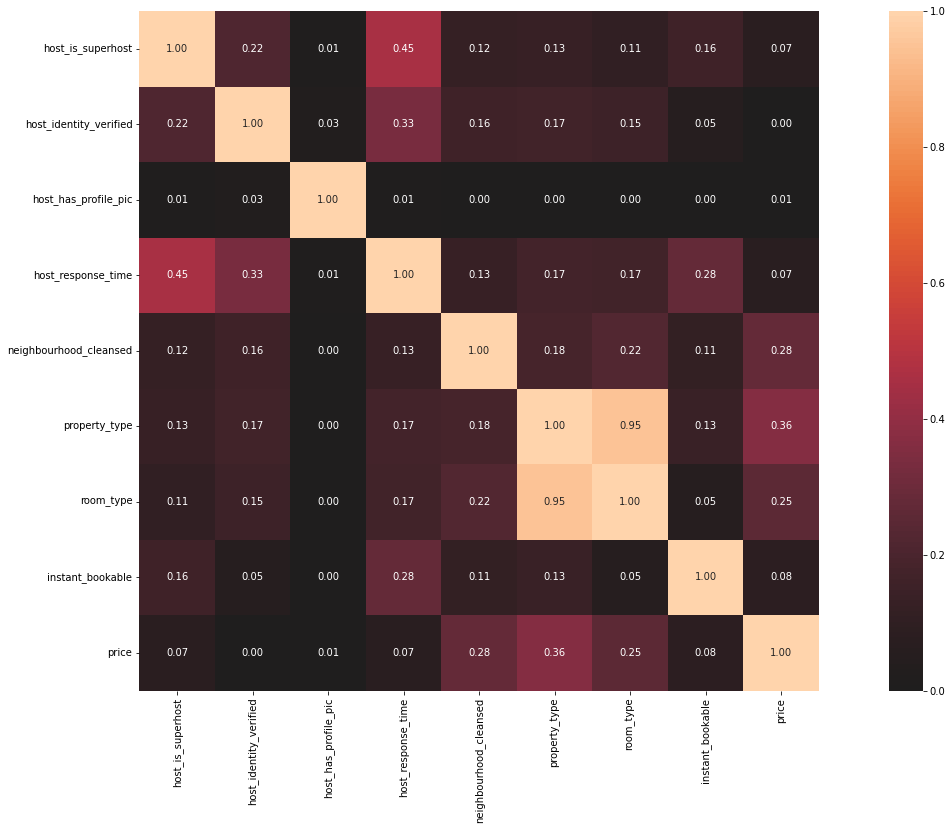

Out[41]: {'corr':                         host_is_superhost  host_identity_verified  \
 host_is_superhost                1.000000                0.216089   
 host_identity_verified           0.216089                1.000000   
 host_has_profile_pic             0.009748                0.028365   
 host_response_time               0.454811                0.334038   
 neighbourhood_cleansed           0.123767                0.159290   
 property_type                    0.130581                0.169114   
 room_type                        0.108076                0.151205   
 instant_bookable                 0.156645                0.048701   
 price                            0.070698                0.004222   
 
                         host_has_profile_pic  host_response_time  \
 host_is_superhost                   0.009748            0.454811   
 host_identity_verified              0.028365            0.334038   
 host_has_profile_pic                1.000000            0.014188   
 host

In [0]:
categoricalCols = [field for (field, dataType) in airbnb_df.dtypes if (dataType == "string")]

numericCols = [field for (field, dataType) in airbnb_df.dtypes if (dataType == "double") & (field != "price")]

associations(airbnb_df.toPandas()[categoricalCols + ['price']], figsize=PLOT_DIMENSIONS, nominal_columns=categoricalCols) 

### 4.2. Analisando as features contínuas

#### 4.2.1. Visualizando o preço

#### 4.2.1.1. A distribuição do preço

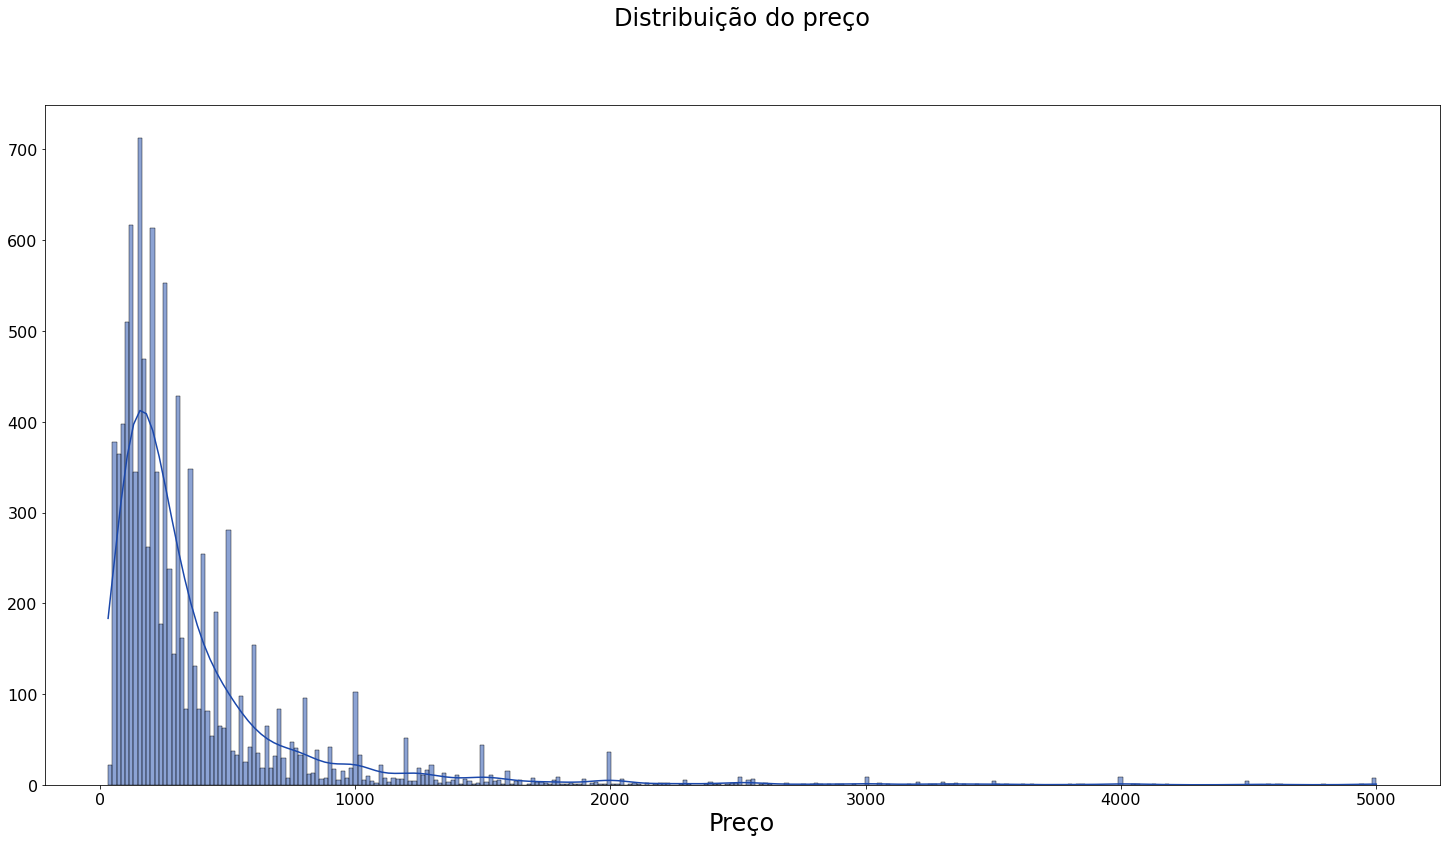

In [0]:
fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)


sns.histplot(data=df["price"], color=MAIN_COLOR, ax=ax, kde=True, bins=300)

plt.xlabel("Preço", fontsize=24)

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição do preço", pad=80, fontsize=24)

plt.show()

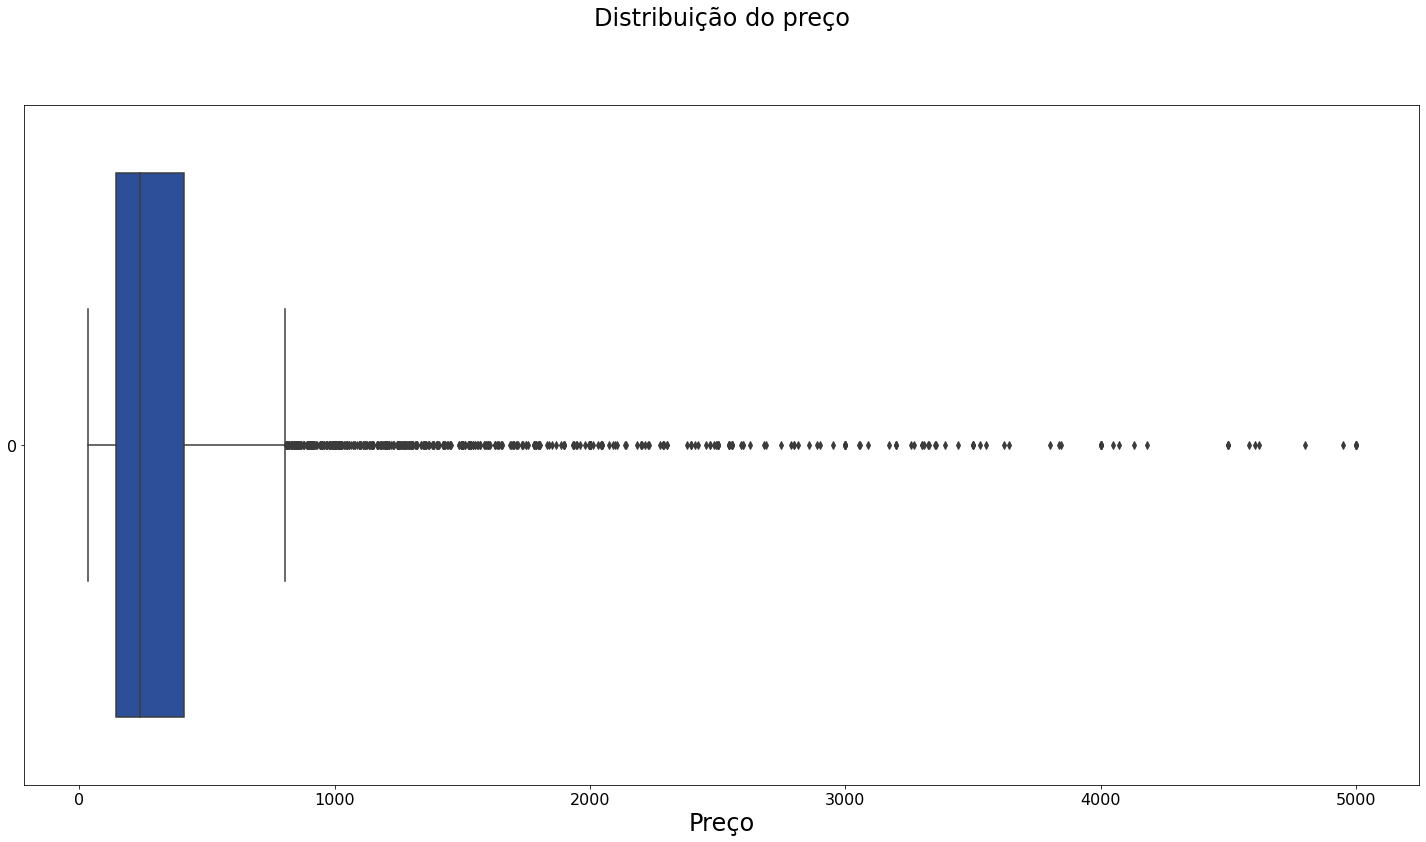

In [0]:
fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)


sns.boxplot(data=df["price"], color=MAIN_COLOR, orient='h', ax=ax)

plt.xlabel("Preço", fontsize=24)

plt.ylabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Distribuição do preço", pad=80, fontsize=24)

plt.show()

### 4.2.1.2 Teste de hipótese

Uma das hipóteses iniciais diz que o preço possuí uma distribuição log-normal. Com isto, iremos utilizar o método de Kolmogorov-Smirnov para verificarmos se devemos ou não aceitar a Hipótese nula que diz respeito a semelhança entre a distribuição log-normal e a distribuição dos preços.

"Em estatística, o teste Kolmogorov–Smirnov (também conhecido como teste KS ou teste K–S) é um teste não paramétrico de bondade do ajuste sobre a igualdade de distribuições de probabilidade contínuas e unidimensionais que pode ser usado para comparar uma amostra com uma distribuição de probabilidade de referência (teste K–S uniamostral) ou duas amostras uma com a outra (teste K–S biamostral).[1] Recebe este nome em homenagem aos matemáticos russos Andrei Kolmogorov e Nikolai Smirnov. " - Wikipedia.

In [0]:
import scipy

# Teste de hipótese

alpha = 0.05

ks_test = scipy.stats.kstest(df["price"], "lognorm", scipy.stats.lognorm.fit(df["price"]))

print(f"O p-value encontrado pelo método de KS: {ks_test.pvalue} \n")

print(f"A distribuição do logarítimo dos preços é {'Log-normal' if ks_test.pvalue > alpha else 'Não log-normal'}")

O p-value encontrado pelo método de KS: 4.2176430292076683e-11 

A distribuição do logarítimo dos preços é Não log-normal


### 4.2.1.3. Visualizando alguns dados estatísticos do preço

In [0]:
airbnb_df.select("price").summary().display()

summary price count 10158 mean 374.0663516440244 stddev 459.0126798636091 min 33.0 25% 143.0 50% 237.0 75% 409.0 max 5000.0

In [0]:
# Visualizando os dados

airbnb_df.limit(5).display()

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable review_scores_accuracy_na review_scores_cleanliness_na review_scores_checkin_na review_scores_communication_na review_scores_location_na review_scores_value_na host_response_rate_na host_acceptance_rate_na wifi essentials long_term_stays_allowed air_conditioning kitchen iron elevator hot_water dishes_and_silverware washer dedicated_workspace hangers refrigerator microwave cooking_basics stove hair_dryer coffee_maker tv_with_standard_cable cable_tv tv oven free_parking_on_premises extra_pillows_and_blankets fire_extinguisher luggage_dropoff_allowed host_greets_you bed_linens free_street_parking f t t within an hour 100.0 98.0 Copacabana -22.96599 -43.1794 Entire condominium 170.0 Entire home/apt 5.0 1.0 2.0 2.0 5.0 19.0 49.0 79.0 317.0 265.0 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true true true false true true true true true true true true true true true true false false false true false true false f t t a few days or more 40.0 21.0 Copacabana -22.97735 -43.19105 Entire apartment 160.0 Entire home/apt 2.0 1.0 1.0 2.0 7.0 29.0 59.0 89.0 316.0 238.0 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true false false false true true false false false false true false true true true false false false false false false true false t f t within an hour 100.0 98.0 Copacabana -22.98107 -43.19136 Entire loft 120.0 Entire home/apt 2.0 1.0 1.0 1.0 3.0 5.0 14.0 26.0 92.0 363.0 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true false true true true true true true false true true true true true true true true true true true false false true true true false true false f t t within an hour 100.0 84.0 Ipanema -22.98591 -43.20302 Entire apartment 1699.0 Entire home/apt 13.0 15.0 6.0 7.0 2.0 17.0 42.0 70.0 324.0 82.0 4.62 4.62 4.64 4.69 4.66 4.92 4.44 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true false true true true true true true true true true true true true true true true false true true true false true false f t t N/A 100.0 100.0 Copacabana -22.98528 -43.19264 Private room in apartment 102.0 Private room 1.0 1.0 1.0 1.0 3.0 29.0 59.0 89.0 89.0 42.0 4.88 4.93 4.86 4.98 5.0 4.98 4.93 t 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 true true true true false true true true true true true true true true true true true true true true true true false true true true false true true

### 4.2.2 Analisando o impacto de features numéricas no preço

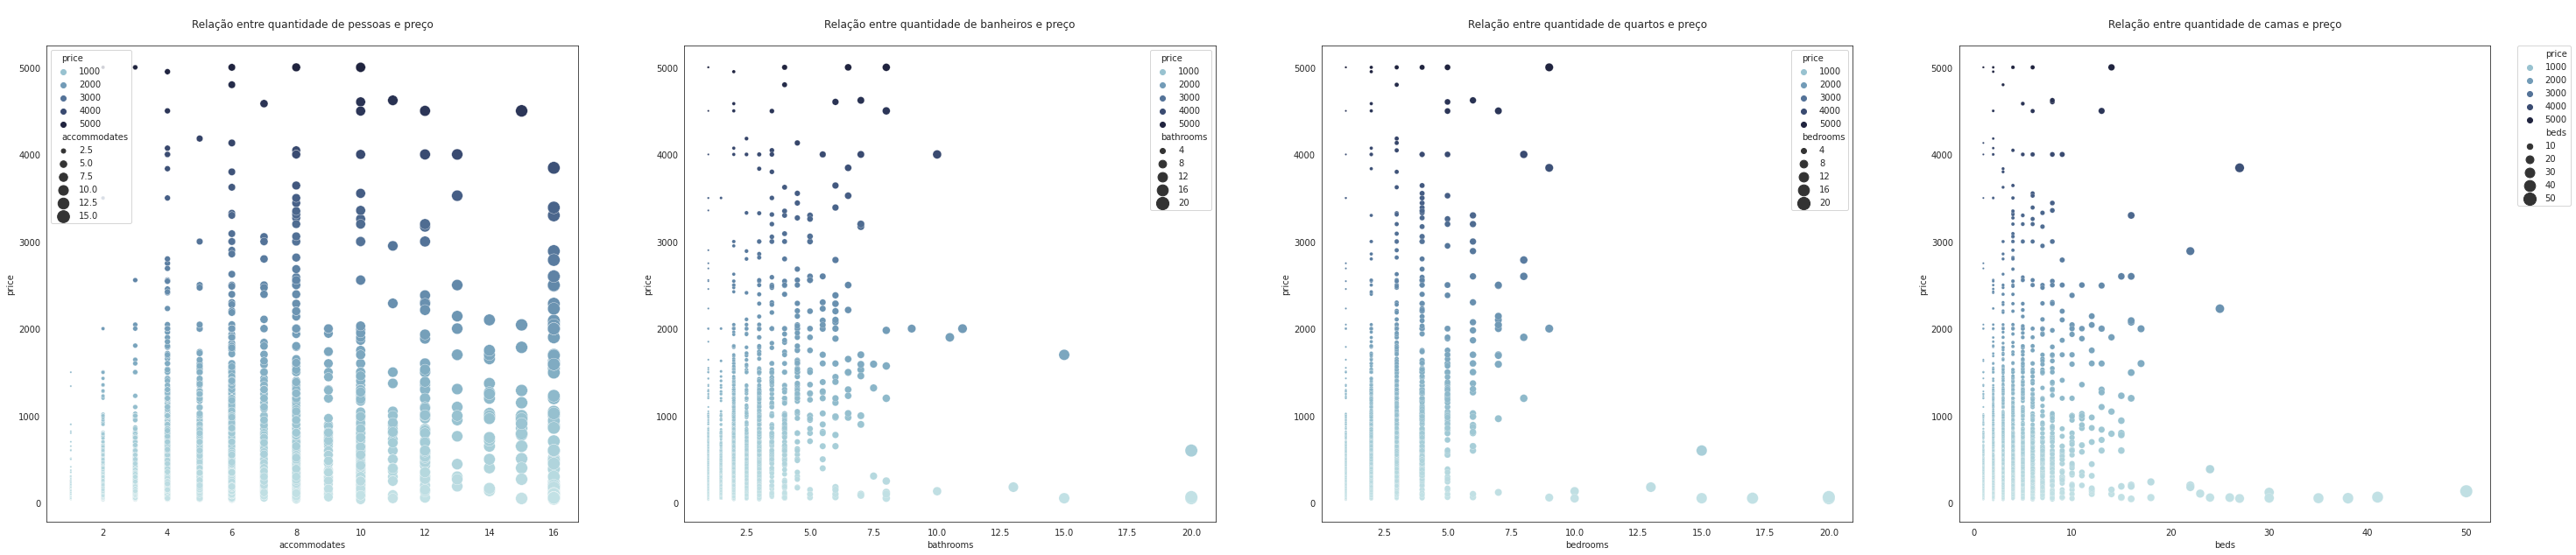

In [0]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

figs, axs = plt.subplots(figsize=(50, 10), ncols=4)

sns.scatterplot(x="accommodates", y="price", size='accommodates', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[0])

axs[0].title.set_text('\nRelação entre quantidade de pessoas e preço\n')


sns.scatterplot(x="bathrooms", y="price", size='bathrooms', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[1])

axs[1].title.set_text('\nRelação entre quantidade de banheiros e preço\n')


sns.scatterplot(x="bedrooms", y="price", size='bedrooms', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[2])

axs[2].title.set_text('\nRelação entre quantidade de quartos e preço\n')

sns.scatterplot(x="beds", y="price", size='beds', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[3])

axs[3].title.set_text('\nRelação entre quantidade de camas e preço\n')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);



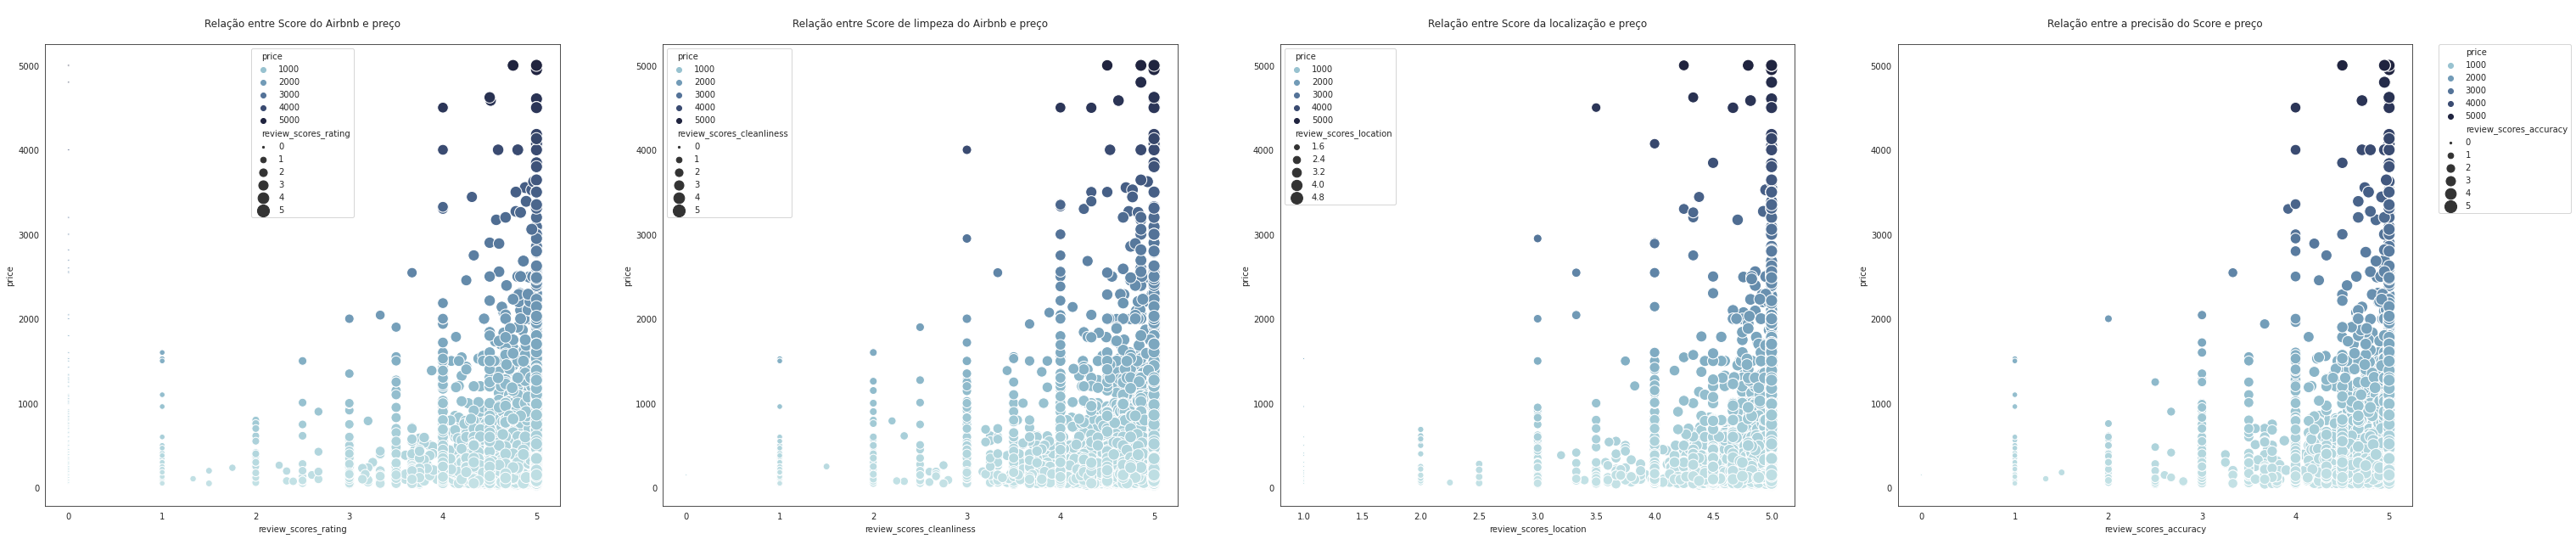

In [0]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

figs, axs = plt.subplots(figsize=(50, 10), ncols=4)

sns.scatterplot(x="review_scores_rating", y="price", size='review_scores_rating', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[0])

axs[0].title.set_text('\nRelação entre Score do Airbnb e preço\n')


sns.scatterplot(x="review_scores_cleanliness", y="price", size='review_scores_cleanliness', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[1])

axs[1].title.set_text('\nRelação entre Score de limpeza do Airbnb e preço\n')


sns.scatterplot(x="review_scores_location", y="price", size='review_scores_location', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[2])

axs[2].title.set_text('\nRelação entre Score da localização e preço\n')

sns.scatterplot(x="review_scores_accuracy", y="price", size='review_scores_accuracy', sizes=(5, 200),
                      hue='price', palette=cmap,  data=df, ax=axs[3])

axs[3].title.set_text('\nRelação entre a precisão do Score e preço\n')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);



Neste momento iremos criar categorias para os preços através do algoritmo de clusterização K-Means. 

O primeiro passo é identificador o valor de K ótimo para o nosso problema, em seguida, iremos clusterizar estes preços e criar um label para cada cluster gerado a fim de facilitar a identificação.

In [0]:

# Criando uma coluna que representa as features para os preços como Vector Assembler

vec_assembler = VectorAssembler(inputCols=["price"], outputCol="price_feature")

sub_df = vec_assembler.transform(airbnb_df)

sub_df.limit(5).display()

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable review_scores_accuracy_na review_scores_cleanliness_na review_scores_checkin_na review_scores_communication_na review_scores_location_na review_scores_value_na host_response_rate_na host_acceptance_rate_na wifi essentials long_term_stays_allowed air_conditioning kitchen iron elevator hot_water dishes_and_silverware washer dedicated_workspace hangers refrigerator microwave cooking_basics stove hair_dryer coffee_maker tv_with_standard_cable cable_tv tv oven free_parking_on_premises extra_pillows_and_blankets fire_extinguisher luggage_dropoff_allowed host_greets_you bed_linens free_street_parking price_feature f t t within an hour 100.0 98.0 Copacabana -22.96599 -43.1794 Entire condominium 170.0 Entire home/apt 5.0 1.0 2.0 2.0 5.0 19.0 49.0 79.0 317.0 265.0 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true true true false true true true true true true true true true true true true false false false true false true false Map(vectorType -> dense, length -> 1, values -> List(170.0)) f t t a few days or more 40.0 21.0 Copacabana -22.97735 -43.19105 Entire apartment 160.0 Entire home/apt 2.0 1.0 1.0 2.0 7.0 29.0 59.0 89.0 316.0 238.0 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true false false false true true false false false false true false true true true false false false false false false true false Map(vectorType -> dense, length -> 1, values -> List(160.0)) t f t within an hour 100.0 98.0 Copacabana -22.98107 -43.19136 Entire loft 120.0 Entire home/apt 2.0 1.0 1.0 1.0 3.0 5.0 14.0 26.0 92.0 363.0 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true false true true true true true true false true true true true true true true true true true true false false true true true false true false Map(vectorType -> dense, length -> 1, values -> List(120.0)) f t t within an hour 100.0 84.0 Ipanema -22.98591 -43.20302 Entire apartment 1699.0 Entire home/apt 13.0 15.0 6.0 7.0 2.0 17.0 42.0 70.0 324.0 82.0 4.62 4.62 4.64 4.69 4.66 4.92 4.44 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true false true true true true true true true true true true true true true true true false true true true false true false Map(vectorType -> dense, length -> 1, values -> List(1699.0)) f t t N/A 100.0 100.0 Copacabana -22.98528 -43.19264 Private room in apartment 102.0 Private room 1.0 1.0 1.0 1.0 3.0 29.0 59.0 89.0 89.0 42.0 4.88 4.93 4.86 4.98 5.0 4.98 4.93 t 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 true true true true false true true true true true true true true true true true true true true true true true false true true true false true true Map(vectorType -> dense, length -> 1, values -> List(102.0))

In [0]:
# Colocando os dados de feature na mesma escala

scale=StandardScaler(inputCol='price_feature',outputCol='standardized')

data_scale=scale.fit(sub_df)

data_scale_output=data_scale.transform(sub_df)

In [0]:
# Preparando os dados para verificar qual valor de k é o ideal para a clusterização do preço 

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='price', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
  KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
  KMeans_fit=KMeans_algo.fit(data_scale_output)
    
  output=KMeans_fit.transform(data_scale_output)
    
  score=evaluator.evaluate(output)
    
  silhouette_score.append(score)
  
  print("Silhouette Score:",score)

Silhouette Score: 0.9637723959853691
Silhouette Score: 0.9637723959853691
Silhouette Score: 0.9637723959853691
Silhouette Score: 0.9637723959853691
Silhouette Score: 0.9637723959853691
Silhouette Score: 0.9637723959853691
Silhouette Score: 0.9637723959853691
Silhouette Score: 0.9637723959853691


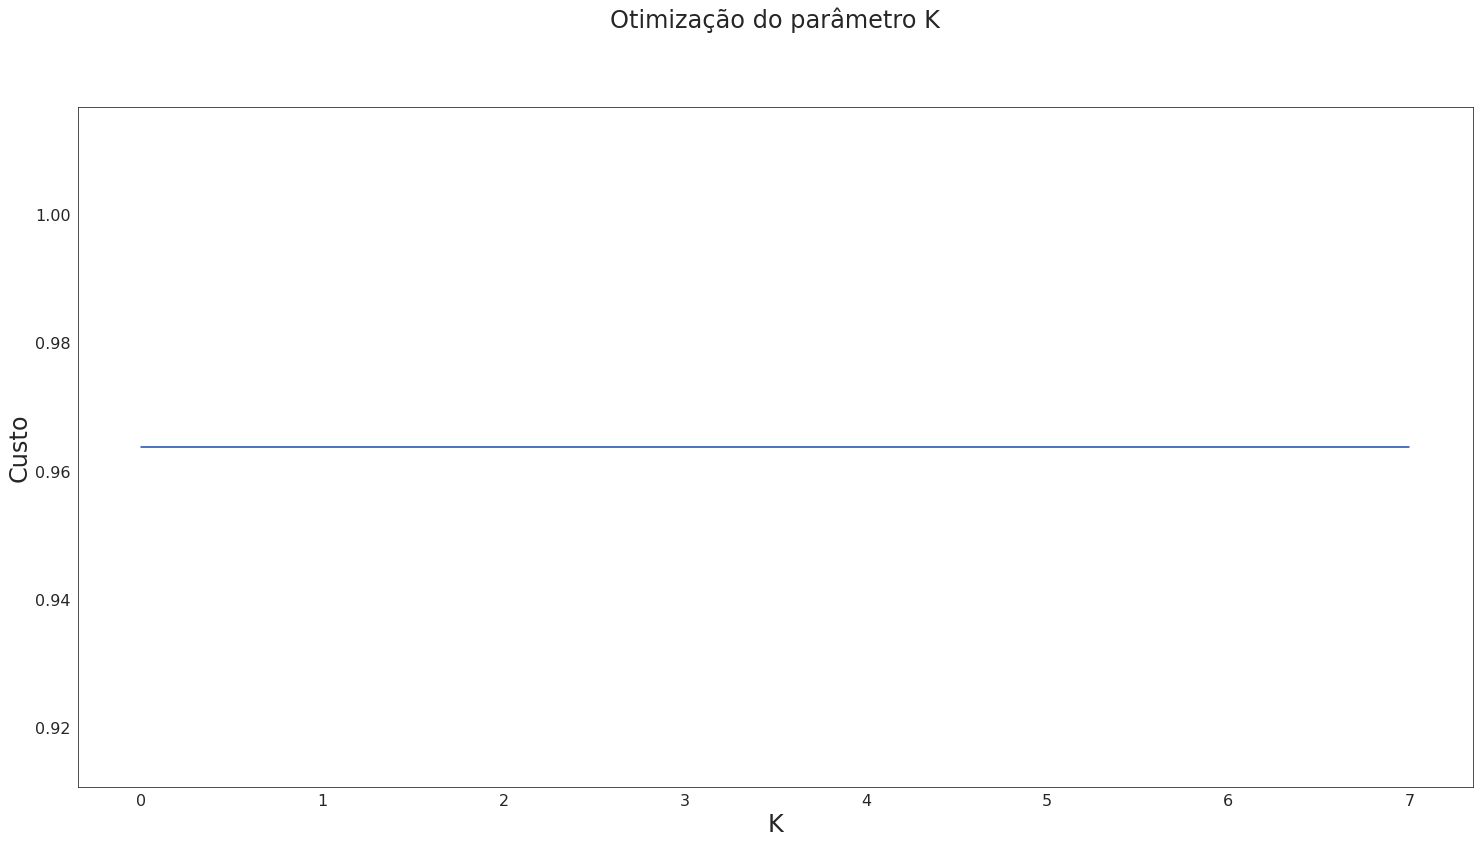

In [0]:
fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.lineplot(data=silhouette_score, color=MAIN_COLOR, ax=ax)

plt.xlabel("K", fontsize=24)

plt.ylabel("Custo", fontsize=24)

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Otimização do parâmetro K", pad=80, fontsize=24)

plt.show()

Neste caso, para qualquer valor de K teremos um valor ótimo. Para fins práticos iremos utilizar 4 clusters.

In [0]:
# Criando o cluster para os preços 

KMeans_algo=KMeans(featuresCol='standardized', k=4)
    
KMeans_fit=KMeans_algo.fit(data_scale_output)
    
clusterized_price_df = KMeans_fit.transform(data_scale_output).toPandas()

clusterized_price_df.head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field price_feature. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


host_is_superhost 
 host_identity_verified 
 host_has_profile_pic 
 host_response_time 
 host_response_rate 
 host_acceptance_rate 
 neighbourhood_cleansed 
 latitude 
 longitude 
 property_type 
 ... 
 free_parking_on_premises 
 extra_pillows_and_blankets 
 fire_extinguisher 
 luggage_dropoff_allowed 
 host_greets_you 
 bed_linens 
 free_street_parking 
 price_feature 
 standardized 
 prediction 
 
 
 
 
 0 
 f 
 t 
 t 
 within an hour 
 100.0 
 98.0 
 Copacabana 
 -22.96599 
 -43.17940 
 Entire condominium 
 ... 
 False 
 False 
 False 
 True 
 False 
 True 
 False 
 [170.0] 
 [0.37036013918071664] 
 2 
 
 
 1 
 f 
 t 
 t 
 a few days or more 
 40.0 
 21.0 
 Copacabana 
 -22.97735 
 -43.19105 
 Entire apartment 
 ... 
 False 
 False 
 False 
 False 
 False 
 True 
 False 
 [160.0] 
 [0.3485742486406745] 
 2 
 
 
 2 
 t 
 f 
 t 
 within an hour 
 100.0 
 98.0 
 Copacabana 
 -22.98107 
 -43.19136 
 Entire loft 
 ... 
 False 
 True 
 True 
 True 
 False 
 True 
 False 
 [120.0] 
 [0.2614306864805059] 
 2 
 
 
 3 
 f 
 t 
 t 
 within an hour 
 100.0 
 84.0 
 Ipanema 
 -22.98591 
 -43.20302 
 Entire apartment 
 ... 
 False 
 True 
 True 
 True 
 False 
 True 
 False 
 [1699.0] 
 [3.701422802753162] 
 0 
 
 
 4 
 f 
 t 
 t 
 N/A 
 100.0 
 100.0 
 Copacabana 
 -22.98528 
 -43.19264 
 Private room in apartment 
 ... 
 False 
 True 
 True 
 True 
 False 
 True 
 True 
 [102.0] 
 [0.22221608350842997] 
 2 
 
 
 
 5 rows × 70 columns

In [0]:
# Método que ordena o cluster

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()

    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)

    df_new['index'] = df_new.index

    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)

    df_final = df_final.drop([cluster_field_name],axis=1)

    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [0]:
clusterized_price_df = order_cluster('prediction', 'price', clusterized_price_df, True)


clusterized_price_df.groupby('prediction')['price'].describe()


count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 prediction 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 7203.0 
 186.337498 
 83.780192 
 33.0 
 120.0 
 179.0 
 250.0 
 372.0 
 
 
 1 
 2217.0 
 559.410014 
 149.688320 
 373.0 
 443.0 
 500.0 
 660.0 
 950.0 
 
 
 2 
 625.0 
 1350.819200 
 345.821028 
 960.0 
 1023.0 
 1254.0 
 1527.0 
 2302.0 
 
 
 3 
 113.0 
 3301.796460 
 792.244079 
 2382.0 
 2557.0 
 3059.0 
 4000.0 
 5000.0

In [0]:
# Criando a label para cada cluster 

clusterized_price_df["label_price"] = "Very High"


clusterized_price_df.loc[clusterized_price_df['prediction'] == 0, 'label_price'] = 'low' 

clusterized_price_df.loc[clusterized_price_df['prediction'] == 1, 'label_price'] = 'medium' 

clusterized_price_df.loc[clusterized_price_df['prediction'] == 2,'label_price'] = 'High' 

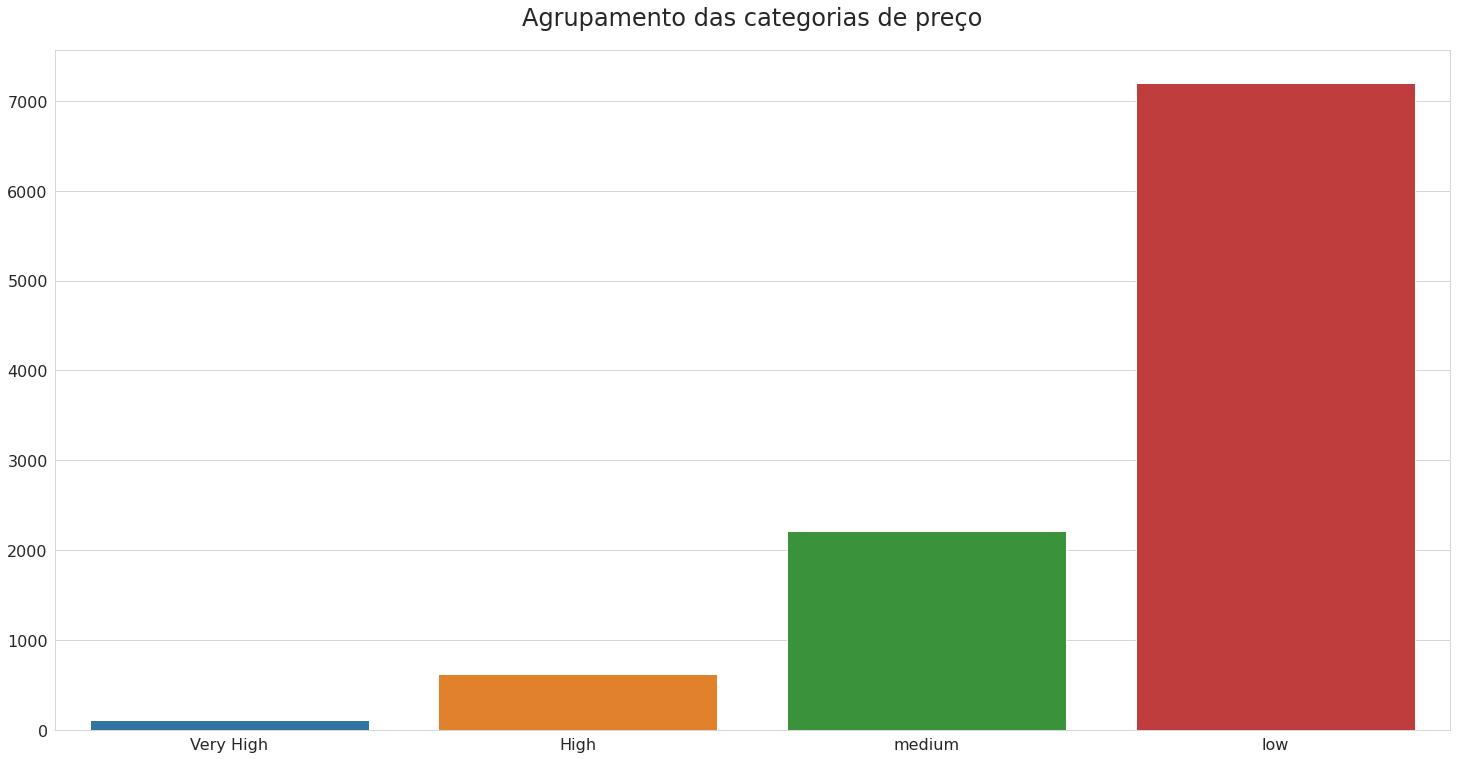

In [0]:
# Visualizando o agrupamento das categoria por preço

sns.set_style("whitegrid")

fig, ax = pyplot.subplots(figsize=PLOT_DIMENSIONS)

sns.barplot(x=clusterized_price_df['label_price'].value_counts(ascending=True).index, y=clusterized_price_df['label_price'].value_counts(ascending=True))

plt.ylabel("")

plt.xlabel("")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Agrupamento das categorias de preço", pad=25, fontsize=24)

plt.show()

### 4.2.3  Analisando correlação das variáveis numéricas

Analisando a correlação das variáveis numéricas utilizando o método Pearson's R.

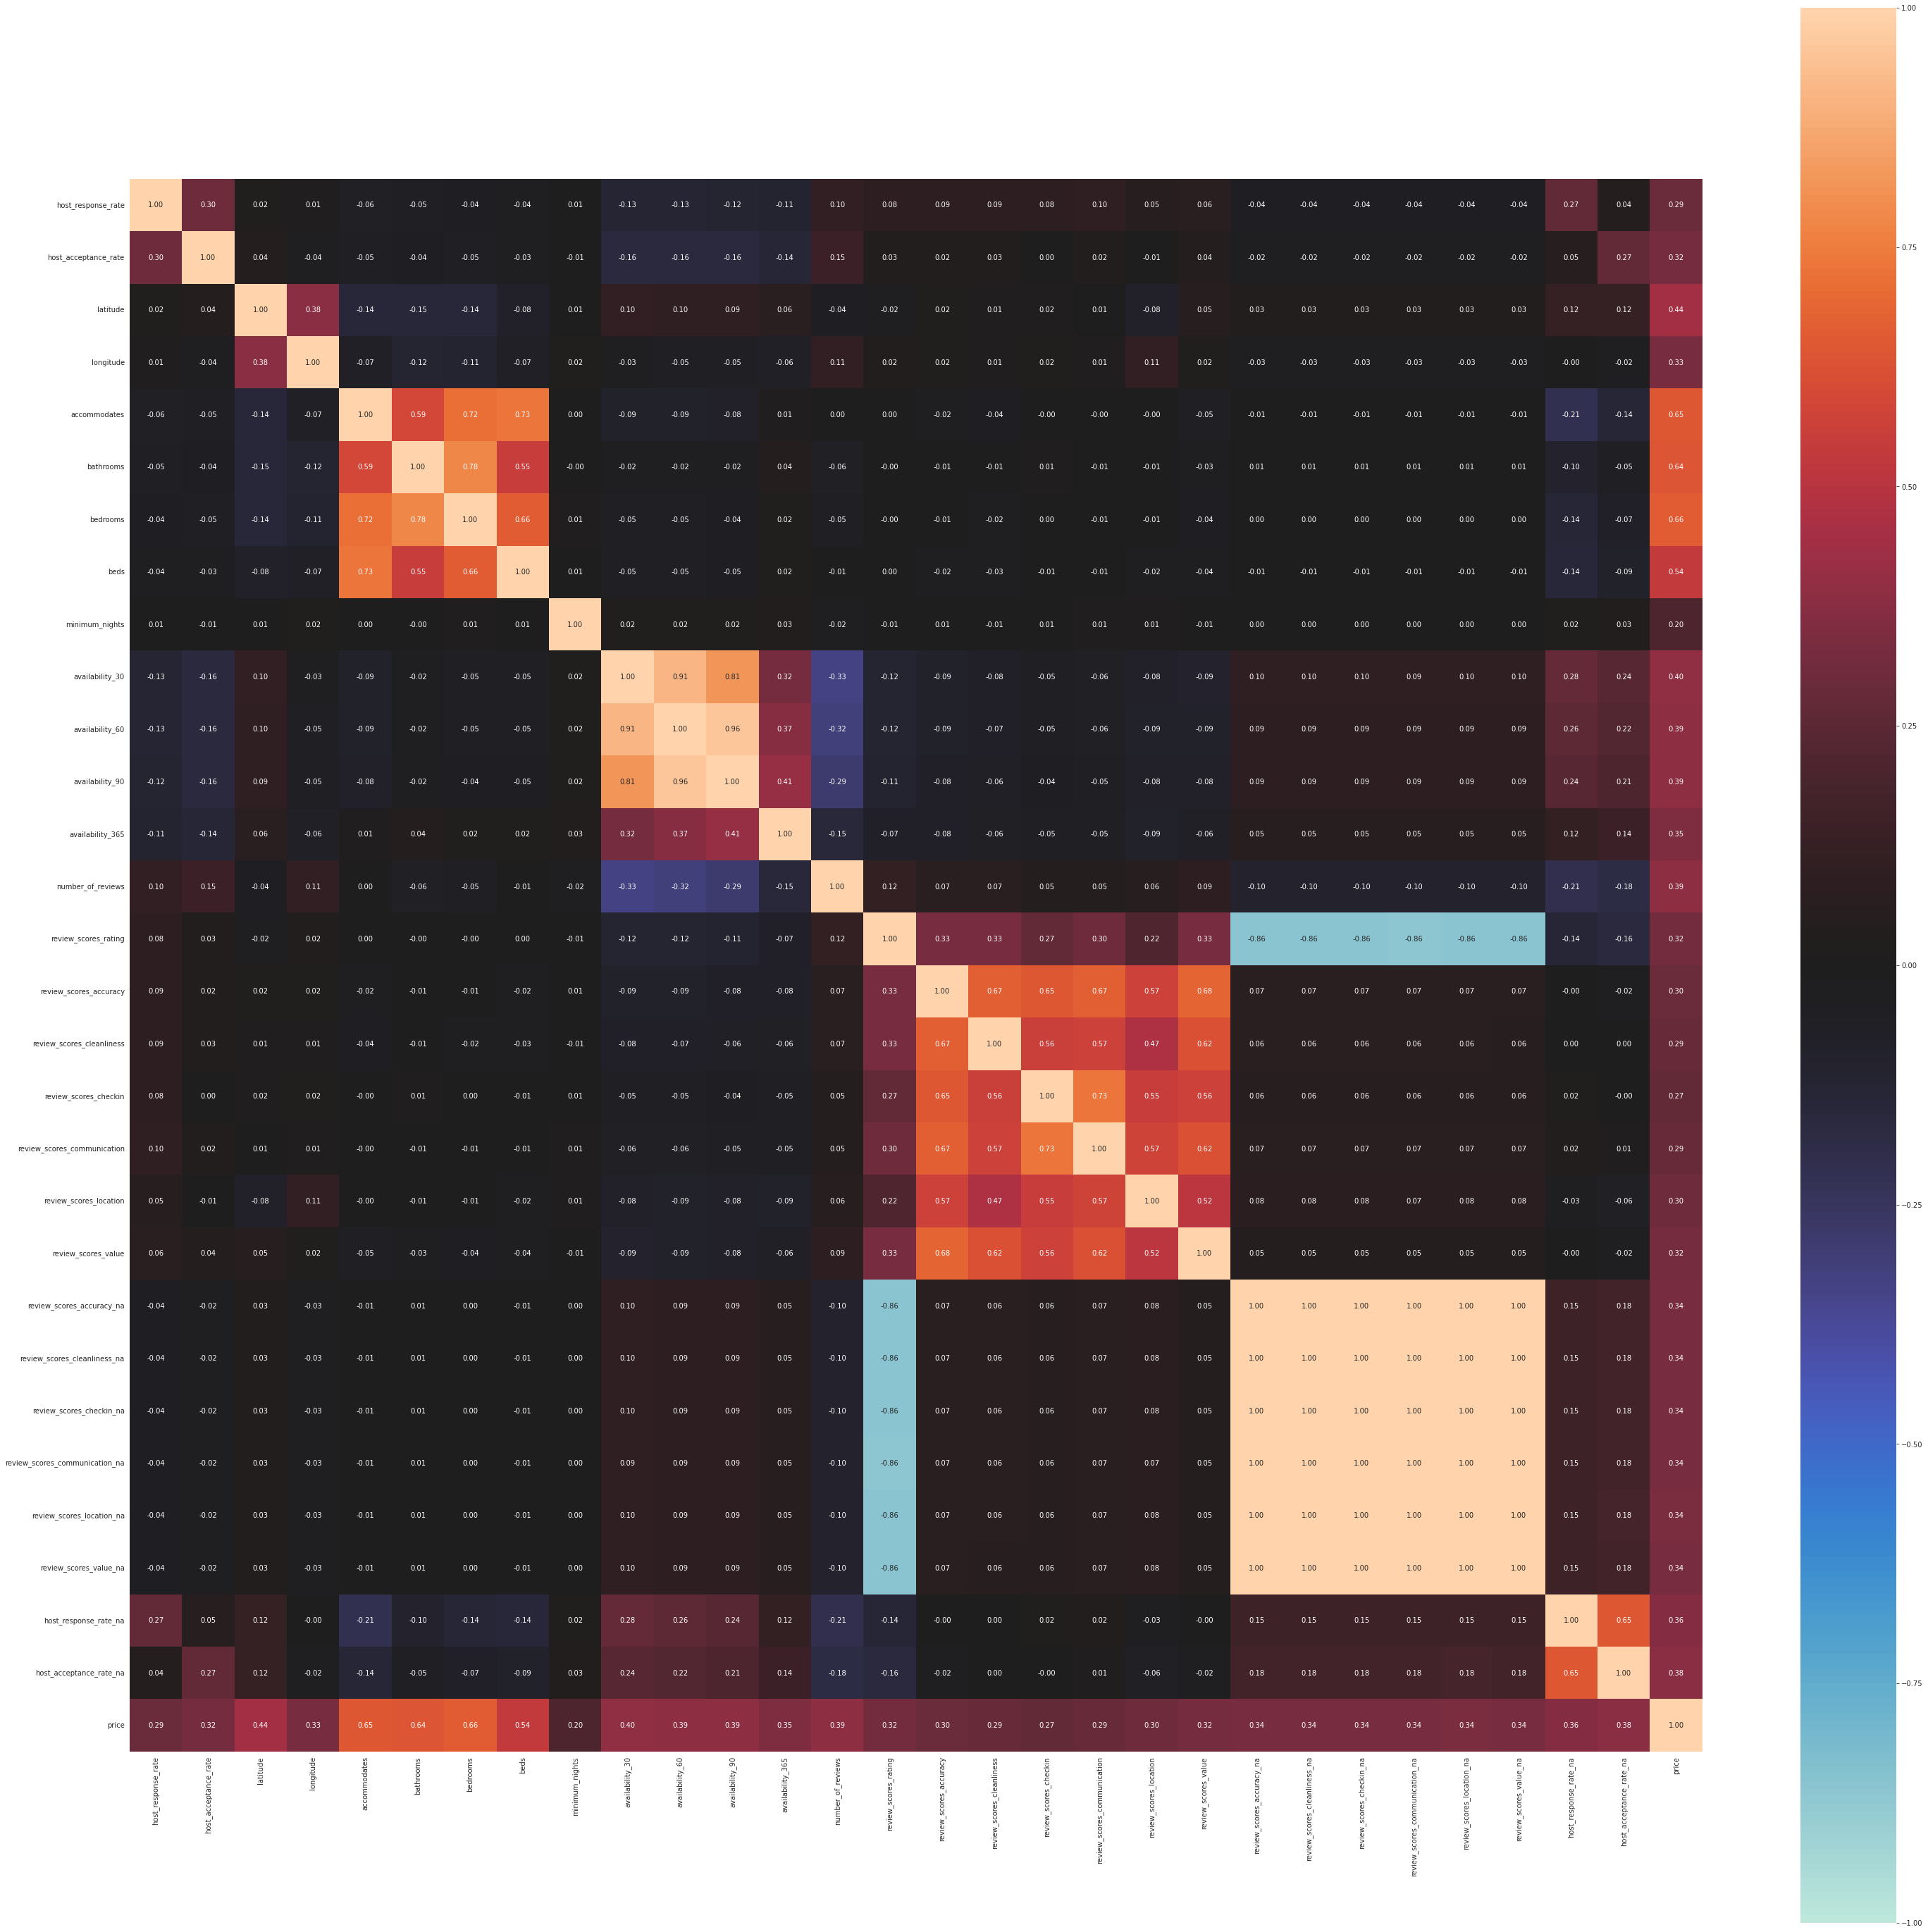

Out[58]: {'corr':                                 host_response_rate  host_acceptance_rate  \
 host_response_rate                        1.000000              0.301302   
 host_acceptance_rate                      0.301302              1.000000   
 latitude                                  0.017549              0.040032   
 longitude                                 0.009488             -0.036896   
 accommodates                             -0.060866             -0.049040   
 bathrooms                                -0.048106             -0.042073   
 bedrooms                                 -0.042901             -0.049374   
 beds                                     -0.038021             -0.032740   
 minimum_nights                            0.006879             -0.012402   
 availability_30                          -0.127620             -0.159431   
 availability_60                          -0.126068             -0.160935   
 availability_90                          -0.124357        

In [0]:
associations(airbnb_df.toPandas()[numericCols + ['price']], figsize=(50,50), numerical_columns=numericCols) 

### 5. Criação do modelo

In [0]:
airbnb_df.display(5)

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable review_scores_accuracy_na review_scores_cleanliness_na review_scores_checkin_na review_scores_communication_na review_scores_location_na review_scores_value_na host_response_rate_na host_acceptance_rate_na wifi essentials long_term_stays_allowed air_conditioning kitchen iron elevator hot_water dishes_and_silverware washer dedicated_workspace hangers refrigerator microwave cooking_basics stove hair_dryer coffee_maker tv_with_standard_cable cable_tv tv oven free_parking_on_premises extra_pillows_and_blankets fire_extinguisher luggage_dropoff_allowed host_greets_you bed_linens free_street_parking f t t within an hour 100.0 98.0 Copacabana -22.96599 -43.1794 Entire condominium 170.0 Entire home/apt 5.0 1.0 2.0 2.0 5.0 19.0 49.0 79.0 317.0 265.0 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true true true false true true true true true true true true true true true true false false false true false true false f t t a few days or more 40.0 21.0 Copacabana -22.97735 -43.19105 Entire apartment 160.0 Entire home/apt 2.0 1.0 1.0 2.0 7.0 29.0 59.0 89.0 316.0 238.0 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true false false false true true false false false false true false true true true false false false false false false true false t f t within an hour 100.0 98.0 Copacabana -22.98107 -43.19136 Entire loft 120.0 Entire home/apt 2.0 1.0 1.0 1.0 3.0 5.0 14.0 26.0 92.0 363.0 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true false true true true true true true false true true true true true true true true true true true false false true true true false true false f t t within an hour 100.0 84.0 Ipanema -22.98591 -43.20302 Entire apartment 1699.0 Entire home/apt 13.0 15.0 6.0 7.0 2.0 17.0 42.0 70.0 324.0 82.0 4.62 4.62 4.64 4.69 4.66 4.92 4.44 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true false true true true true true true true true true true true true true true true false true true true false true false f t t N/A 100.0 100.0 Copacabana -22.98528 -43.19264 Private room in apartment 102.0 Private room 1.0 1.0 1.0 1.0 3.0 29.0 59.0 89.0 89.0 42.0 4.88 4.93 4.86 4.98 5.0 4.98 4.93 t 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 true true true true false true true true true true true true true true true true true true true true true true false true true true false true true f f t within a day 70.0 95.0 Barra da Tijuca -23.00451 -43.30873 Entire house 3171.0 Entire home/apt 12.0 7.0 4.0 7.0 1.0 30.0 60.0 90.0 365.0 7.0 4.57 4.86 4.86 4.86 4.57 4.71 4.57 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 true true true true true true true true false true true true false false false false true false true true true false true true false false false true false f t t within a day 89.0 0.0 Joá -23.00809 -43.29113 Entire house 1169.0 Entire home/apt 10.0 4.0 4.0 5.0 2.0 28.0 58.0 88.0 357.0 13.0 5.0 5.0 4.92 4.92 4.92 4.92 4.75 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true false true true false true true true true true true true true true true true true true true false false true false false false true true f t t within an hour 100.0 84.0 Ipanema -22.98599 -43.20299 Entire apartment 1528.0 Entire home/apt 6.0 7.0 3.0 7.0 2.0 17.0 42.0 70.0 324.0 66.0 4.38 4.23 4.63 4.7 4.5 4.98 4.23 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true false true true true true true true true true true true true true true true false false

In [0]:
# Gerando o split de treinamento e teste em 33% dos dados 

(trainDF, testDF) = airbnb_df.randomSplit([.8, .33], seed=42)

#### 5.1 Regressão Linear

A fim de simplicidade, iremos validar como o modelo se comporta utilizando uma Regressão Linear simples.

In [0]:
rFormula = RFormula(formula="price ~ .", featuresCol="features", labelCol="price", handleInvalid="skip") # Look at handleInvalid

lr = LinearRegression(labelCol="price", featuresCol="features")

pipelineLr = Pipeline(stages = [rFormula, lr])

pipelineLrModel = pipelineLr.fit(trainDF)

In [0]:
# Montando o dataframe de predição com os dados de teste

predDF = pipelineLrModel.transform(testDF)


In [0]:
# Avaliando o modelo 

regressionEvaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

rmse = regressionEvaluator.setMetricName("rmse").evaluate(predDF)

r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)

with mlflow.start_run(run_name="Airbnb - Rio de Janeiro - LR Model") as run:
  mlflow.log_metric("rmse", rmse)
  
  mlflow.log_metric("r2", r2)
  
  mlflow.spark.log_model(pipelineLrModel, "airbnb-rj-price-prediction-lr-model")
  
    
print(f"O RMSE dos dados de teste: {rmse}")

print(f"O R2 dos dados de teste: {r2}")

O RMSE dos dados de teste: 340.18957178239054
O R2 dos dados de teste: 0.4188380642407705


In [0]:
# Salvando o modelo criado via mlflow

#model_name = f"airbnb_rio-de-janeiro_lr_model"

#run_id = run.info.run_id
#model_uri = f"runs:/{run_id}/model"

#model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

In [0]:
# Adicionando um comentário ao modelo 

#client = MlflowClient()

#client.update_registered_model(
#  name=model_details.name,
#  version=model_details.version,
#  description="Este modelo de Regressão Linear tem como objetivo a predição dos valores de Airbnb do Estado do Rio de Janeiro."
#)

#### 5.2 Random Forest

In [0]:
# Preparando os dados para a criação do modelo de Random Forest

categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]

indexOutputCols = [x + "Index" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")

numericCols = [field for (field, dataType) in trainDF.dtypes if ((dataType == "double") & (field != "price"))]

assemblerInputs = indexOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")


In [0]:
# Criando o modelo de Random Forest

rf = RandomForestRegressor(labelCol="price", maxBins=124)

In [0]:
# Utilizando o Param Grid para encontrar os melhores parâmetros para o modelo de Random Forest

paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [8, 16])
            .addGrid(rf.numTrees, [8, 32])
            .build())

In [0]:
# Utilizando Cross Validation para encontrar os melhores parâmetros para o modelo de Random Forest
rFormula = RFormula(formula="price ~ .", featuresCol="features", labelCol="price", handleInvalid="skip") # Look at handleInvalid

evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

cv = CrossValidator(estimator=rf, evaluator=evaluator, estimatorParamMaps=paramGrid, 
                    numFolds=3, parallelism=4, seed=42)

stagesWithCV = [rFormula, cv]

pipelineCvModel = Pipeline(stages=stagesWithCV)

pipelineRfModel = pipelineCvModel.fit(trainDF)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


In [0]:
# Criando o dataframe de predição do preço com o modelo de Random Forest criado

predDF = pipelineRfModel.transform(testDF)

In [0]:
# Avaliando o modelo 

regressionEvaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

rmse = regressionEvaluator.setMetricName("rmse").evaluate(predDF)

r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)

with mlflow.start_run(run_name="Airbnb - Rio de Janeiro - LR Model") as run:
  mlflow.log_metric("rmse", rmse)
  
  mlflow.log_metric("r2", r2)
  
  mlflow.spark.log_model(pipelineRfModel, "airbnb-rj-price-prediction-rf-model")
  
    
print(f"O RMSE dos dados de teste: {rmse}")

print(f"O R2 dos dados de teste: {r2}")

O RMSE dos dados de teste: 325.6091146815404
O R2 dos dados de teste: 0.4675874605538316


In [0]:
# Salvando o modelo criado via mlflow

#model_name = f"airbnb_rio-de-janeiro_rf_model"

#run_id = run.info.run_id
#model_uri = f"runs:/{run_id}/model"

#model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

In [0]:
# Adicionando um comentário ao modelo 

#client = MlflowClient()

#client.update_registered_model(
#  name=model_details.name,
#  version=model_details.version,
#  description="Este modelo de Random Forest tem como objetivo a predição dos valores de Airbnb do Estado do Rio de Janeiro."
#)

In [0]:
# Salvando o melhor modelo de Random Forest
rf_model  = pipelineRfModel.stages[-1].bestModel

In [0]:
# Visualizando as features mais importantes para o modelo de RandomF orest
from itertools import chain

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*predDF
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))


feature_importance = [(name, rf_model.featureImportances[idx]) for idx, name in attrs if rf_model.featureImportances[idx]]

feature_importance_df = pd.DataFrame(feature_importance, columns=["feature", "importance"])

feature_importance_df.sort_values(by="importance", ascending=False)

feature 
 importance 
 
 
 
 
 145 
 bathrooms 
 1.596357e-01 
 
 
 146 
 bedrooms 
 1.496936e-01 
 
 
 144 
 accommodates 
 5.090586e-02 
 
 
 91 
 latitude 
 4.836861e-02 
 
 
 92 
 longitude 
 3.939431e-02 
 
 
 ... 
 ... 
 ... 
 
 
 70 
 neighbourhood_cleansed_Catumbi 
 1.259701e-08 
 
 
 79 
 neighbourhood_cleansed_Cidade de Deus 
 6.602660e-09 
 
 
 80 
 neighbourhood_cleansed_Gericinó 
 4.345558e-09 
 
 
 78 
 neighbourhood_cleansed_Bento Ribeiro 
 1.036962e-09 
 
 
 75 
 neighbourhood_cleansed_Ramos 
 5.381966e-10 
 
 
 
 199 rows × 2 columns

In [0]:
# Exportando os dados

airbnb_df.write.csv("/csv/" + OUTPUT_DATASET_PATH )


In [0]:
# Criando uma tabela com os dados

airbnb_df.write.saveAsTable("airbnb_rj_june_listings")

In [0]:
airbnb_df.display()

host_is_superhost host_identity_verified host_has_profile_pic host_response_time host_response_rate host_acceptance_rate neighbourhood_cleansed latitude longitude property_type price room_type accommodates bathrooms bedrooms beds minimum_nights availability_30 availability_60 availability_90 availability_365 number_of_reviews review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable review_scores_accuracy_na review_scores_cleanliness_na review_scores_checkin_na review_scores_communication_na review_scores_location_na review_scores_value_na host_response_rate_na host_acceptance_rate_na wifi essentials long_term_stays_allowed air_conditioning kitchen iron elevator hot_water dishes_and_silverware washer dedicated_workspace hangers refrigerator microwave cooking_basics stove hair_dryer coffee_maker tv_with_standard_cable cable_tv tv oven free_parking_on_premises extra_pillows_and_blankets fire_extinguisher luggage_dropoff_allowed host_greets_you bed_linens free_street_parking f t t within an hour 100.0 98.0 Copacabana -22.96599 -43.1794 Entire condominium 170.0 Entire home/apt 5.0 1.0 2.0 2.0 5.0 19.0 49.0 79.0 317.0 265.0 4.68 4.78 4.63 4.82 4.9 4.76 4.65 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true true true false true true true true true true true true true true true true false false false true false true false f t t a few days or more 40.0 21.0 Copacabana -22.97735 -43.19105 Entire apartment 160.0 Entire home/apt 2.0 1.0 1.0 2.0 7.0 29.0 59.0 89.0 316.0 238.0 4.68 4.65 4.76 4.77 4.9 4.81 4.56 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true true false false false true true false false false false true false true true true false false false false false false true false t f t within an hour 100.0 98.0 Copacabana -22.98107 -43.19136 Entire loft 120.0 Entire home/apt 2.0 1.0 1.0 1.0 3.0 5.0 14.0 26.0 92.0 363.0 4.9 4.93 4.93 4.96 4.94 4.93 4.87 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true false true true true true true true false true true true true true true true true true true true false false true true true false true false f t t within an hour 100.0 84.0 Ipanema -22.98591 -43.20302 Entire apartment 1699.0 Entire home/apt 13.0 15.0 6.0 7.0 2.0 17.0 42.0 70.0 324.0 82.0 4.62 4.62 4.64 4.69 4.66 4.92 4.44 t 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true false true true true true true true true true true true true true true true true false true true true false true false f t t N/A 100.0 100.0 Copacabana -22.98528 -43.19264 Private room in apartment 102.0 Private room 1.0 1.0 1.0 1.0 3.0 29.0 59.0 89.0 89.0 42.0 4.88 4.93 4.86 4.98 5.0 4.98 4.93 t 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 true true true true false true true true true true true true true true true true true true true true true true false true true true false true true f f t within a day 70.0 95.0 Barra da Tijuca -23.00451 -43.30873 Entire house 3171.0 Entire home/apt 12.0 7.0 4.0 7.0 1.0 30.0 60.0 90.0 365.0 7.0 4.57 4.86 4.86 4.86 4.57 4.71 4.57 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 true true true true true true true true false true true true false false false false true false true true true false true true false false false true false f t t within a day 89.0 0.0 Joá -23.00809 -43.29113 Entire house 1169.0 Entire home/apt 10.0 4.0 4.0 5.0 2.0 28.0 58.0 88.0 357.0 13.0 5.0 5.0 4.92 4.92 4.92 4.92 4.75 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true false true true false true true true true true true true true true true true true true true false false true false false false true true f t t within an hour 100.0 84.0 Ipanema -22.98599 -43.20299 Entire apartment 1528.0 Entire home/apt 6.0 7.0 3.0 7.0 2.0 17.0 42.0 70.0 324.0 66.0 4.38 4.23 4.63 4.7 4.5 4.98 4.23 f 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 true true true true true true false true true true true true true true true true true true true true true false false

### 6. Conclusões

Como podemos perceber, o modelo de Regressão Linear em comparação com o modelo de Random Forest gerado é um bom modelo para predição de preços da diária de Airbnbs na cidade do Rio de Janeiro. Além disso, as features *bathrooms, bedrooms,accommodates, latitude e longitude* são as features mais importantes para o nosso modelo. 

Com o desenvolvimento foi percebido que os modelos de regressão utilizados são altamente influenciados por outliers, uma informação que ajudaria a resolver este problema seria o tamanho da locação, pois algumas locações possuem a mesma quantidade de banheiros, quartos, cama e localização porém se diferem no tamanho da propriedade o que acaba gerando uma grande discrepância nos preços - informação que não é repassada diretamente no dataset - entretando, quando limitados os preços para até R$2.000 reais temos um desempenho melhor na generalização do modelo. 

Vale ressaltar que, de fato, bairros mais próximo ao literal tendem a ter um maior valor médio e a maioria dos Airbnb se enquadram em um Cluster de preço que vão até o máximo R$ 1.000 o valor da diária. 

Estas análises tem muito valor tanto para quem quer viajar e encontrar um bom lugar com o melhor preço e para pessoas que pretendem colocar seu apartamento ou casa para locação no Airbnb saber a média de preço que ele pode cobrar de acordo com as características da locação.